In [1]:
# =========================
# COMUNES
# =========================
# Aquí viven TODAS las constantes “globales” del notebook.
# La idea: cambias algo aquí y el resto de celdas se enteran automáticamente.

import os
import warnings
from pathlib import Path

import numpy as np
import pandas as pd

# --- Ruido / reproducibilidad ---
SEED = 42
np.random.seed(SEED)

# --- Split por defecto ---
SPLIT = "training"        # "training" | "validation" | "test"

# --- Tipos de embeddings disponibles ---
EMB_TYPES = ["ae", "pca"] # puedes dejar ["ae"] si solo quieres AE

# --- Ventanas (wXX) a analizar ---
# Intentamos usar la config oficial del proyecto; si no existe, usamos fallback.
try:
    from educational_ai_analytics.config import EMBEDDINGS_DATA_DIR, FEATURES_DATA_DIR, W_WINDOWS
    WS_TO_PLOT = list(W_WINDOWS)
    EMBEDDINGS_BASE_DIR = Path(EMBEDDINGS_DATA_DIR)
    FEATURES_BASE_DIR = Path(FEATURES_DATA_DIR)
except Exception:
    WS_TO_PLOT = [12, 18, 24]
    # Fallbacks típicos del repo (ajusta si tu estructura es distinta)
    EMBEDDINGS_BASE_DIR = Path("/workspace/TFM_education_ai_analytics/data/4_embeddings")
    FEATURES_BASE_DIR   = Path("/workspace/TFM_education_ai_analytics/data/3_features")

# --- Etiquetas / target (para colorear o evaluar por outcome) ---
LABEL_COL = "final_result"
TARGET_PATH = FEATURES_BASE_DIR / SPLIT / "target.csv"
# Alias por compatibilidad con celdas antiguas
LABELS_PATH = TARGET_PATH

# Mapeos típicos del dataset (si tus labels difieren, ajusta aquí)
OUTCOMES = ["Distinction", "Pass", "Fail", "Withdrawn"]
OUTCOME_COLORS = {
    "Distinction": "#f1c40f",
    "Pass": "#4c78a8",
    "Fail": "#e45756",
    "Withdrawn": "#f4a261",
}
MAP_NUM_TO_STR = {3: "Distinction", 2: "Pass", 1: "Fail", 0: "Withdrawn"}

# Variante usada en alguna visualización previa
LABELS_MAP = MAP_NUM_TO_STR
COLORS_MAP = {3: "#FFD700", 2: "#4A79B7", 1: "#C54443", 0: "#E39063"}


# --- Límites de muestreo (para que no reviente la RAM ni se eternice) ---
MAX_POINTS_PLOT    = 30000   # para plots 2D/3D
MAX_POINTS_METRICS = 30000   # para métricas (silhouette, etc.)

# Límites específicos que aparecen en celdas antiguas
MAX_POINTS_ELBOW       = MAX_POINTS_PLOT
MAX_POINTS_SILHOUETTE  = MAX_POINTS_METRICS
MAX_POINTS_HIERARCHICAL= 30000
# --- Rango de K por defecto ---
K_RANGE = range(2, 11)      # 2..10

# --- KMeans ---
N_INIT = 20                 # robustez en inicialización

# --- Jerárquico ---
LINKAGE = "ward"            # "ward" suele ir fino con euclídea

# --- Varios ---
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # por si hay TF instalado (silencia warnings)
warnings.filterwarnings("ignore")

ROOT = EMBEDDINGS_BASE_DIR

print("✅ COMUNES cargado | SPLIT =", SPLIT, "| WS_TO_PLOT =", WS_TO_PLOT, "| EMB_TYPES =", EMB_TYPES)

✅ COMUNES cargado | SPLIT = training | WS_TO_PLOT = [10, 14, 18, 24] | EMB_TYPES = ['ae', 'pca']


# Exploración de Clustering (II)

Este notebook reúne varias “pruebas de realidad” para escoger **número de clusters** y comparar enfoques (K-Means, GMM y Jerárquico) sobre embeddings (AE / PCA) generados por el proyecto.

> Nota práctica: he centralizado **todas las constantes** en la primera celda (**COMUNES**) para que el resto de celdas “tiren” de ahí. Dentro de cada sección verás además una celda inicial con *config de la sección* (sin duplicar constantes globales).


## 1. K-Means

Aquí calculamos **Elbow** e **índice de Silhouette** para varios `wXX` y tipos de embedding. La heurística: buscamos un codo razonable *y* una silhouette que no sea triste.

In [2]:
# Configuración de la sección (K-Means)
# Nota: si quieres cambiar constantes “globales”, ve a la celda COMUNES.
KMEANS_K_RANGE = K_RANGE
KMEANS_N_INIT  = N_INIT


🔍 Analizando semanas configuradas en config.py: [10, 14, 18, 24]
⏳ Procesando AE | Semana 10...
⏳ Procesando AE | Semana 14...


KeyboardInterrupt: 

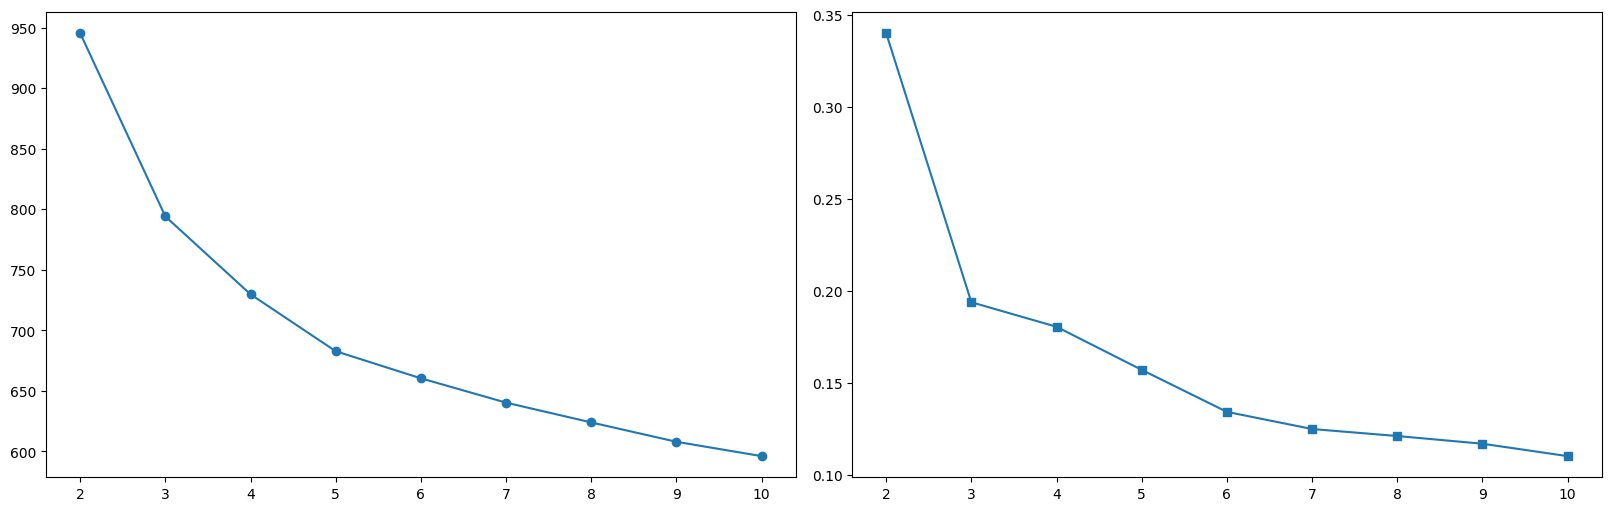

In [3]:
# 📈 Elbow + Silhouette basado en W_WINDOWS de config.py
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# Silenciar warnings ruidosos
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.filterwarnings("ignore", category=UserWarning)
# =========================

def safe_read_csv(path: Path) -> pd.DataFrame:
    if not path.exists(): return pd.DataFrame()
    return pd.read_csv(path, index_col=0).replace([np.inf, -np.inf], np.nan).fillna(0.0)

def file_for(split_dir: Path, W: int, emb_type: str) -> Path:
    return split_dir / f"upto_w{W:02d}" / f"{emb_type}_latent.csv"

def compute_metrics(X: np.ndarray, k_range, seed=SEED, n_init=N_INIT):
    inertias = []
    silhouettes = []
    
    # Submuestreo para Silueta por rendimiento
    X_sub = X
    if len(X) > MAX_POINTS_SILHOUETTE:
        idx = np.random.RandomState(seed).choice(len(X), MAX_POINTS_SILHOUETTE, replace=False)
        X_sub = X[idx]
        
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=seed, n_init=n_init)
        labels = km.fit_predict(X)
        inertias.append(km.inertia_)
        
        # Validar consistencia de etiquetas para la silueta
        avg_s = silhouette_score(X_sub, km.predict(X_sub), random_state=seed)
        silhouettes.append(avg_s)
        
    return inertias, silhouettes

# ---------- ejecución ----------
split_dir = ROOT / SPLIT
print(f"🔍 Analizando semanas configuradas en config.py: {WS_TO_PLOT}")

available_types = [t for t in EMB_TYPES if any(file_for(split_dir, W, t).exists() for W in WS_TO_PLOT)]

for emb_type in available_types:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), constrained_layout=True)
    
    for W in WS_TO_PLOT:
        path = file_for(split_dir, W, emb_type)
        if not path.exists():
            print(f"⚠️  W{W:02d} no encontrada en {path.parent.name}, saltando...")
            continue
            
        df = safe_read_csv(path)
        if df.empty: continue
        
        if len(df) > MAX_POINTS_ELBOW:
            df = df.sample(n=MAX_POINTS_ELBOW, random_state=SEED)
        
        X = df.values.astype(np.float32)
        print(f"⏳ Procesando {emb_type.upper()} | Semana {W}...")
        inertias, silhouettes = compute_metrics(X, K_RANGE)

        # Gráficas
        ax1.plot(list(K_RANGE), inertias, marker="o", label=f"W{W}")
        ax2.plot(list(K_RANGE), silhouettes, marker="s", label=f"W{W}")

    # Estilo Inercia
    ax1.set_title(f"Elbow Method | {emb_type.upper()}")
    ax1.set_xlabel("k (# clusters)")
    ax1.set_ylabel("Inertia (SSE)")
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.legend(title="Semanas")

    # Estilo Silueta
    ax2.set_title(f"Silhouette Score | {emb_type.upper()}")
    ax2.set_xlabel("k (# clusters)")
    ax2.set_ylabel("Avg Silhouette Score")
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.legend(title="Semanas")
    
    plt.show()

print("✅ Análisis finalizado basado en W_WINDOWS.")

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from IPython.display import display, Markdown

# Silenciar ruidos
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.filterwarnings("ignore")

# ---- Configuración de Rutas y Datos ----
try:
    from educational_ai_analytics.config import EMBEDDINGS_DATA_DIR, FEATURES_DATA_DIR, W_WINDOWS
    ROOT = Path(EMBEDDINGS_DATA_DIR)
except Exception:
    ROOT = Path("/workspace/TFM_education_ai_analytics/data/4_embeddings")

# ===============================================

def safe_read_csv(path: Path) -> pd.DataFrame:
    if not path.exists(): return pd.DataFrame()
    return pd.read_csv(path, index_col=0).replace([np.inf, -np.inf], np.nan).fillna(0.0)

# Cargar Target
df_target = pd.read_csv(TARGET_PATH, index_col=0)
global_success = (df_target["final_result"] >= 2).mean() * 100

# ==========================================
# 1. CÁLCULO DE MÉTRICAS Y TABLA SUMMARY
# ==========================================
metrics_results = []

for W in WS_TO_PLOT:
    for emb_type in EMB_TYPES:
        path = ROOT / SPLIT / f"upto_w{W:02d}" / f"{emb_type}_latent.csv"
        if not path.exists(): continue
        
        df_lat = safe_read_csv(path)
        common_idx = df_lat.index.intersection(df_target.index)
        df_lat = df_lat.loc[common_idx]
        
        # Muestreo para métricas
        if len(df_lat) > MAX_POINTS_METRICS:
            df_lat = df_lat.sample(n=MAX_POINTS_METRICS, random_state=SEED)
            
        X = StandardScaler().fit_transform(df_lat.values.astype(np.float32))
        km = KMeans(n_clusters=K, n_init=10, random_state=SEED)
        labels = km.fit_predict(X)
        
        # Computar métricas
        s_score = silhouette_score(X, labels)
        ch_score = calinski_harabasz_score(X, labels)
        db_score = davies_bouldin_score(X, labels)
        
        metrics_results.append({
            "Semana": W, "Embedding": emb_type.upper(), 
            "Silueta": s_score, "Calinski-Harabasz": ch_score, "Davies-Bouldin": db_score
        })

# Generar DataFrame Pivot para la tabla final
df_stats = pd.DataFrame(metrics_results)
summary_table = []

# Definición de las métricas para la tabla
metric_meta = [
    ("Silueta", "Maximizar", "Mide qué tan similar es un objeto a su propio clúster en comparación con otros. (-1 a 1)"),
    ("Calinski-Harabasz", "Maximizar", "Ratio entre la dispersión entre clústeres y la dispersión dentro de ellos."),
    ("Davies-Bouldin", "Minimizar", "Mide la similitud media entre cada clúster y su clúster más similar.")
]

for name, obj, desc in metric_meta:
    for W in WS_TO_PLOT:
        row = {"Métrica": f"{name} (W{W})", "Objetivo": obj, "Descripción": desc}
        for emb in ["PCA", "AE"]:
            val = df_stats[(df_stats["Semana"] == W) & (df_stats["Embedding"] == emb)][name].values
            row[f"Valor {emb}"] = f"{val[0]:.4f}" if len(val) > 0 else "N/A"
        summary_table.append(row)

display(Markdown("### 📊 Comparativa de Calidad de Clustering: PCA vs Autoencoder"))
display(pd.DataFrame(summary_table)[["Métrica", "Valor PCA", "Valor AE", "Objetivo", "Descripción"]])

# ==========================================
# 2. GENERACIÓN DE GRÁFICOS (REORDENADOS)
# ==========================================
def plot_educational_breakdown(ax, df_combined, title):
    counts = df_combined.groupby(["cluster", "final_result"]).size().unstack(fill_value=0)
    percentages = counts.div(counts.sum(axis=1), axis=0) * 100
    width = 0.2
    x = np.arange(len(percentages))
    for i, res_val in enumerate([3, 2, 1, 0]):
        if res_val in percentages.columns:
            ax.bar(x + (i-1.5)*width, percentages[res_val], width, 
                   label=LABELS_MAP[res_val], color=COLORS_MAP[res_val], alpha=0.9)
    ax.axhline(global_success, color="black", linestyle="--", alpha=0.4)
    ax.set_title(title, fontsize=10, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f"Riesgo {i}" if i==0 else (f"Top {i}" if i==K-1 else f"G{i}") for i in range(len(percentages))])
    ax.set_ylim(0, 115)
    ax.grid(axis='y', linestyle=':', alpha=0.5)

split_dir = ROOT / SPLIT
Ws = [W for W in WS_TO_PLOT if any((split_dir / f"upto_w{W:02d}" / f"{t}_latent.csv").exists() for t in EMB_TYPES)]
nrows = len(Ws)
fig, axes = plt.subplots(nrows, 4, figsize=(22, 6 * nrows), constrained_layout=True)
if nrows == 1: axes = np.expand_dims(axes, axis=0)

for i, W in enumerate(Ws):
    for j, emb_type in enumerate(EMB_TYPES):
        col_scatter, col_bar = j*2, j*2+1
        df_lat = safe_read_csv(split_dir / f"upto_w{W:02d}" / f"{emb_type}_latent.csv")
        common_idx = df_lat.index.intersection(df_target.index)
        df_lat = df_lat.loc[common_idx]
        if len(df_lat) > MAX_POINTS_PLOT:
            df_lat = df_lat.sample(n=MAX_POINTS_PLOT, random_state=SEED)
            common_idx = df_lat.index
        
        X_plot = StandardScaler().fit_transform(df_lat.values.astype(np.float32))
        km = KMeans(n_clusters=K, n_init=15, random_state=SEED)
        raw_clusters = km.fit_predict(X_plot)
        
        # Reordenar por riesgo
        temp_df = pd.DataFrame({"cluster": raw_clusters, "res": df_target.loc[common_idx, "final_result"]})
        risk_rates = temp_df.groupby("cluster")["res"].apply(lambda x: (x == 0).mean()).sort_values(ascending=False)
        reorder_map = {old: new for new, old in enumerate(risk_rates.index)}
        ordered_clusters = [reorder_map[c] for c in raw_clusters]
        
        # PCA Scatter
        Z = PCA(n_components=2, random_state=SEED).fit_transform(X_plot)
        axes[i, col_scatter].scatter(Z[:, 0], Z[:, 1], c=ordered_clusters, s=5, cmap="Set1", alpha=0.6)
        axes[i, col_scatter].set_title(f"W{W} | {emb_type.upper()} (Vista PCA)")
        
        # Bars
        df_res = pd.DataFrame({"cluster": ordered_clusters}, index=common_idx).join(df_target)
        plot_educational_breakdown(axes[i, col_bar], df_res, f"Frecuencias (W{W} {emb_type.upper()})")

handles, labels = axes[0, 1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=5, frameon=False)
plt.show()

NameError: name 'TARGET_PATH' is not defined

## 2. GMM

Gaussian Mixture Models (GMM) nos permite clusters elípticos y suele ir bien cuando K-Means se queda “geométricamente corto”. Aquí miramos **BIC/AIC** y, si cuadra, también métricas tipo silhouette.

In [ ]:
# Configuración de la sección (GMM)
GMM_K_RANGE   = K_RANGE
GMM_N_INIT    = 5          # n_init del GMM (puede ser más caro)
GMM_REG_COVAR = 1e-6       # estabiliza cuando hay covarianzas “feas”


🔍 ROOT: /workspace/TFM_education_ai_analytics/data/4_embeddings
🔍 SPLIT: training
🔍 Evaluando GMM (cov=diag, n_init=5, reg_covar=1e-06) para semanas: [12, 18, 24]
⏳ Ajustando GMM para AE | Semana W12 | n=22785 ...
⏳ Ajustando GMM para AE | Semana W18 | n=22785 ...
⏳ Ajustando GMM para AE | Semana W24 | n=22785 ...


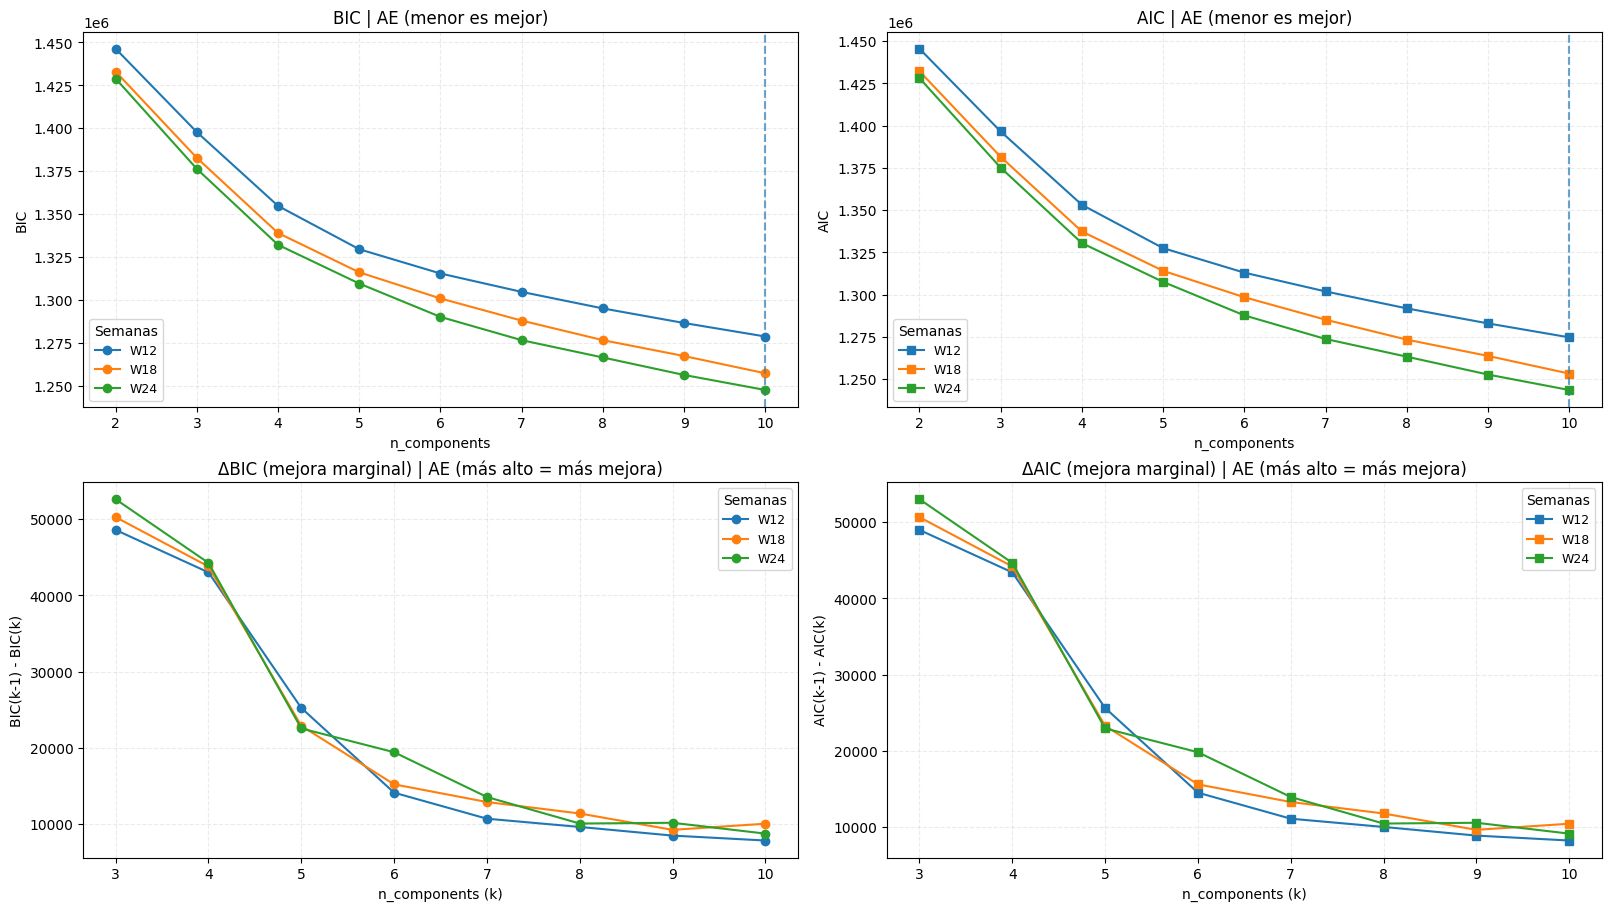

⏳ Ajustando GMM para PCA | Semana W12 | n=22785 ...
⏳ Ajustando GMM para PCA | Semana W18 | n=22785 ...
⏳ Ajustando GMM para PCA | Semana W24 | n=22785 ...


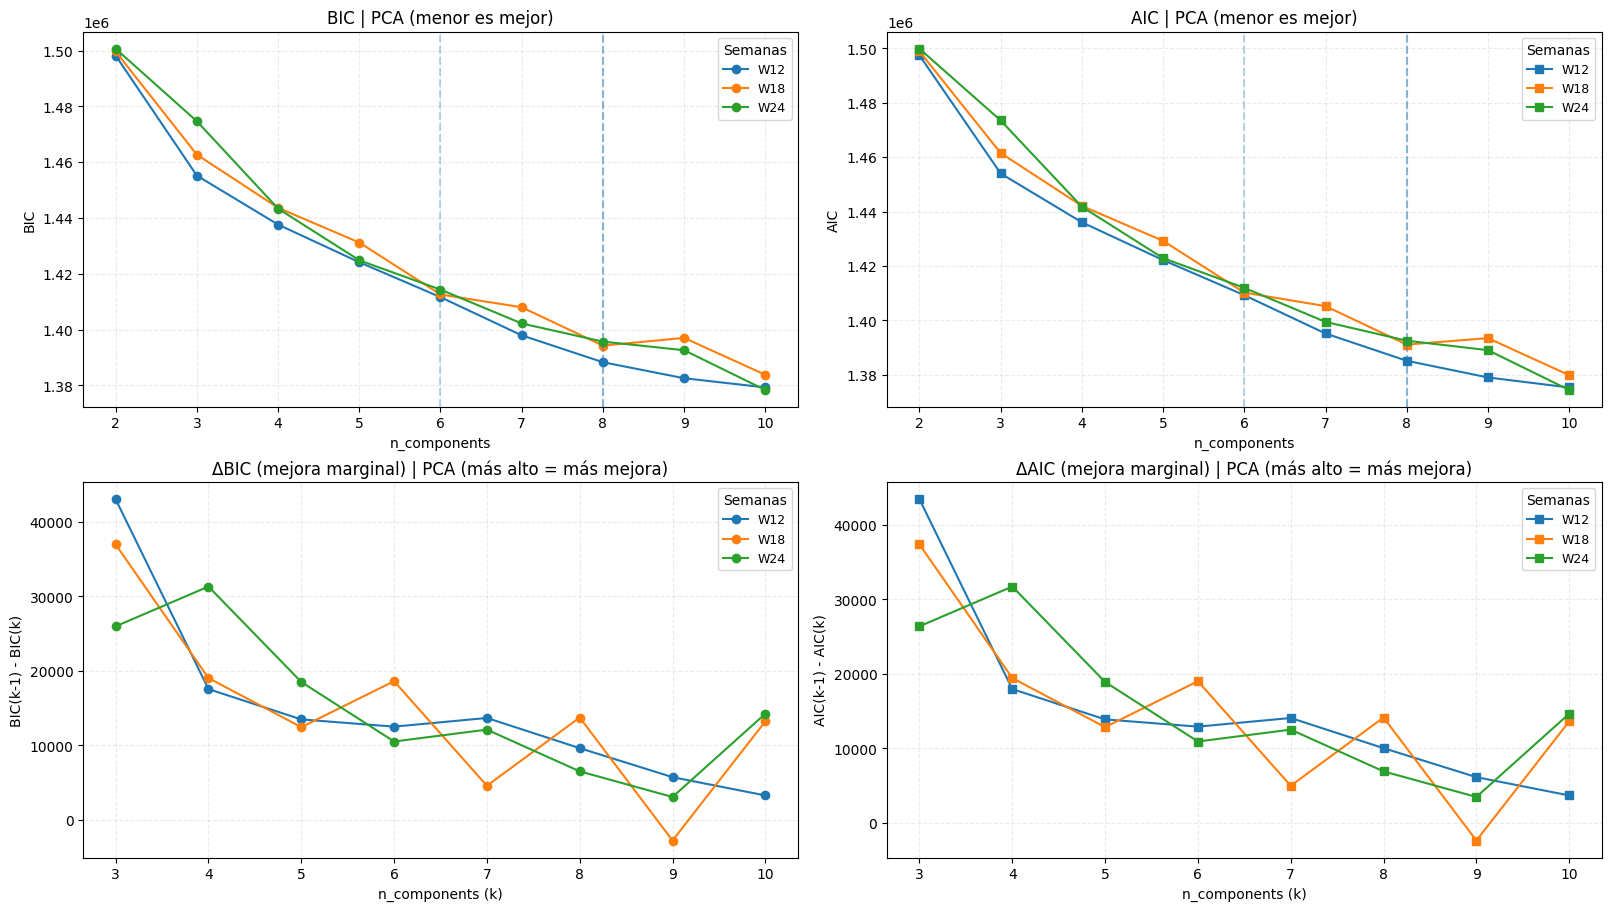


📌 Resumen (por W y tipo):


,emb_type,W,n_points_used,k_best_BIC,k_best_AIC,k_knee_BIC,k_knee_AIC,all_converged
0,ae,12,22785,10,10,10,10,True
1,ae,18,22785,10,10,10,10,True
2,ae,24,22785,10,10,10,10,True
3,pca,12,22785,10,10,8,8,True
4,pca,18,22785,10,10,6,6,True
5,pca,24,22785,10,10,8,8,True



✅ Análisis de GMM finalizado.
Tip: si ves BIC/AIC monótonos, mira ΔBIC/ΔAIC para 'diminishing returns'. Puedes ajustar KNEE_DROP_FRACTION=0.15 (0.10–0.25 suele ir bien).


In [ ]:
# 📊 Análisis de GMM (BIC/AIC) dinámico y ROBUSTO
# - Lee 4_embeddings/<split>/upto_wXX/{ae|pca}_latent.csv
# - Submuestrea
# - Escala (StandardScaler) ✅
# - GMM con n_init>1 + reg_covar + control de warnings ✅
# - Plots BIC/AIC + mejoras marginales (Δ) para ver "diminishing returns" ✅
# - Imprime tabla resumen con k_best por BIC/AIC y k_sugerido por "knee" (heurística simple) ✅

import re
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# -----------------------------
# Configuración del proyecto (si existe)
# -----------------------------
try:
    from educational_ai_analytics.config import EMBEDDINGS_DATA_DIR, W_WINDOWS
    ROOT = Path(EMBEDDINGS_DATA_DIR)
    # (centralizado en COMUNES) WS_TO_PLOT = list(W_WINDOWS)
except Exception:
    ROOT = Path("4_embeddings")     # fallback
    # (centralizado en COMUNES) WS_TO_PLOT = [12, 18, 24]

# ========= CONFIG =========
# (centralizado en COMUNES) SPLIT = "training"                 # "training" | "validation" | "test"
# (centralizado en COMUNES) EMB_TYPES = ["ae", "pca"]          # ["ae"] si solo quieres AE
# (centralizado en COMUNES) K_RANGE = range(2, 11)             # n_components a testear
MAX_POINTS_GMM = 30000             # submuestreo
# (centralizado en COMUNES) SEED = 42
COV_TYPE = "diag"                  # "full" | "diag" | "tied" | "spherical"
# (centralizado en COMUNES) N_INIT = 5                         # evita óptimos locales
REG_COVAR = 1e-6                   # estabilidad numérica
MAX_ITER = 300
# Heurística "knee": elegimos el primer k donde la mejora marginal cae por debajo de este % de la mejora inicial
KNEE_DROP_FRACTION = 0.15          # 15% (ajústalo 0.1-0.25)
# =========================


def safe_read_csv(path: Path) -> pd.DataFrame:
    if not path.exists():
        return pd.DataFrame()
    return (
        pd.read_csv(path, index_col=0)
        .replace([np.inf, -np.inf], np.nan)
        .fillna(0.0)
    )


def file_for(split_dir: Path, W: int, emb_type: str) -> Path:
    return split_dir / f"upto_w{W:02d}" / f"{emb_type}_latent.csv"


def list_weeks(split_dir: Path) -> list[int]:
    ws = []
    for p in split_dir.iterdir():
        if p.is_dir():
            m = re.match(r"upto_w(\d+)$", p.name)
            if m:
                ws.append(int(m.group(1)))
    return sorted(ws)


def compute_gmm_selection(X: np.ndarray, k_range):
    """
    Devuelve:
      bics: list[float]
      aics: list[float]
      converged: list[bool]
    """
    bics, aics, convs = [], [], []
    for k in k_range:
        try:
            gmm = GaussianMixture(
                n_components=k,
                covariance_type=COV_TYPE,
                random_state=SEED,
                n_init=N_INIT,
                reg_covar=REG_COVAR,
                max_iter=MAX_ITER,
            )
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                gmm.fit(X)

            bics.append(float(gmm.bic(X)))
            aics.append(float(gmm.aic(X)))
            convs.append(bool(getattr(gmm, "converged_", True)))
        except Exception:
            bics.append(np.nan)
            aics.append(np.nan)
            convs.append(False)

    return bics, aics, convs


def knee_from_scores(scores: list[float], ks: list[int], drop_fraction: float = 0.15):
    """
    Heurística simple para "knee" cuando la curva baja monótonamente:
    - Calcula mejoras marginales: improvement(k) = score(k-1) - score(k)  (queremos score más bajo)
    - Toma mejora inicial (entre k_min y k_min+1) como referencia.
    - Devuelve el primer k donde improvement(k) < drop_fraction * improvement_initial.
    Si no encuentra, devuelve el último k.
    """
    s = np.array(scores, dtype=float)
    k = np.array(ks, dtype=int)

    # Si hay NaNs, no podemos hacer heurística fiable
    if np.any(~np.isfinite(s)) or len(s) < 3:
        return int(k[len(k)//2]) if len(k) else None

    improvements = s[:-1] - s[1:]  # cuánto mejora al subir k
    base = improvements[0]
    if base <= 0:
        # no está mejorando o es raro; devuelve el primer k válido
        return int(k[0])

    thresh = drop_fraction * base
    for idx in range(1, len(improvements)):
        if improvements[idx] < thresh:
            return int(k[idx])  # k correspondiente al "segundo" de ese salto
    return int(k[-1])


def argmin_k(scores: list[float], ks: list[int]):
    s = np.array(scores, dtype=float)
    k = np.array(ks, dtype=int)
    mask = np.isfinite(s)
    if not np.any(mask):
        return None
    return int(k[mask][np.argmin(s[mask])])


# ---------- ejecución ----------
split_dir = ROOT / SPLIT
if not split_dir.exists():
    raise FileNotFoundError(f"No existe split_dir: {split_dir.resolve()}")

# Si WS_TO_PLOT viene de config y no coincide con carpetas reales, filtramos
existing_ws = set(list_weeks(split_dir))
if existing_ws:
    # (centralizado en COMUNES) WS_TO_PLOT = [w for w in WS_TO_PLOT if w in existing_ws] or sorted(existing_ws)

print(f"🔍 ROOT: {ROOT.resolve()}")
print(f"🔍 SPLIT: {SPLIT}")
print(f"🔍 Evaluando GMM (cov={COV_TYPE}, n_init={N_INIT}, reg_covar={REG_COVAR}) para semanas: {WS_TO_PLOT}")

available_types = [t for t in EMB_TYPES if any(file_for(split_dir, W, t).exists() for W in WS_TO_PLOT)]
if not available_types:
    raise RuntimeError(f"No se encontraron embeddings {EMB_TYPES} en {split_dir.resolve()}")

summary_rows = []

KS = list(K_RANGE)

for emb_type in available_types:
    fig, axes = plt.subplots(2, 2, figsize=(16, 9), constrained_layout=True)
    ax_bic, ax_aic = axes[0, 0], axes[0, 1]
    ax_dbic, ax_daic = axes[1, 0], axes[1, 1]

    for W in WS_TO_PLOT:
        path = file_for(split_dir, W, emb_type)
        if not path.exists():
            continue

        df = safe_read_csv(path)
        if df.empty:
            continue

        if len(df) > MAX_POINTS_GMM:
            df = df.sample(n=MAX_POINTS_GMM, random_state=SEED)

        X = df.values.astype(np.float32)

        # ✅ Escalado recomendado
        X = StandardScaler().fit_transform(X)

        print(f"⏳ Ajustando GMM para {emb_type.upper()} | Semana W{W:02d} | n={len(df)} ...")
        bics, aics, convs = compute_gmm_selection(X, K_RANGE)

        # Best ks
        k_bic = argmin_k(bics, KS)
        k_aic = argmin_k(aics, KS)
        k_knee_bic = knee_from_scores(bics, KS, drop_fraction=KNEE_DROP_FRACTION)
        k_knee_aic = knee_from_scores(aics, KS, drop_fraction=KNEE_DROP_FRACTION)

        summary_rows.append({
            "emb_type": emb_type,
            "W": W,
            "n_points_used": len(df),
            "k_best_BIC": k_bic,
            "k_best_AIC": k_aic,
            "k_knee_BIC": k_knee_bic,
            "k_knee_AIC": k_knee_aic,
            "all_converged": bool(np.all(convs)) if len(convs) else False,
        })

        # Plot BIC / AIC
        ax_bic.plot(KS, bics, marker="o", label=f"W{W:02d}")
        ax_aic.plot(KS, aics, marker="s", label=f"W{W:02d}")

        # Plot mejoras marginales (Δ): cuanto baja al aumentar k
        b = np.array(bics, dtype=float)
        a = np.array(aics, dtype=float)

        # improvements: score(k-1) - score(k)
        db = b[:-1] - b[1:]
        da = a[:-1] - a[1:]

        ax_dbic.plot(KS[1:], db, marker="o", label=f"W{W:02d}")
        ax_daic.plot(KS[1:], da, marker="s", label=f"W{W:02d}")

        # Marcar sugerencias (knee) con líneas verticales ligeras
        if k_knee_bic is not None:
            ax_bic.axvline(k_knee_bic, linestyle="--", alpha=0.3)
        if k_knee_aic is not None:
            ax_aic.axvline(k_knee_aic, linestyle="--", alpha=0.3)

    # Estilo
    ax_bic.set_title(f"BIC | {emb_type.upper()} (menor es mejor)")
    ax_bic.set_xlabel("n_components")
    ax_bic.set_ylabel("BIC")
    ax_bic.grid(True, alpha=0.25, linestyle="--")
    ax_bic.legend(title="Semanas", fontsize=9)

    ax_aic.set_title(f"AIC | {emb_type.upper()} (menor es mejor)")
    ax_aic.set_xlabel("n_components")
    ax_aic.set_ylabel("AIC")
    ax_aic.grid(True, alpha=0.25, linestyle="--")
    ax_aic.legend(title="Semanas", fontsize=9)

    ax_dbic.set_title(f"ΔBIC (mejora marginal) | {emb_type.upper()} (más alto = más mejora)")
    ax_dbic.set_xlabel("n_components (k)")
    ax_dbic.set_ylabel("BIC(k-1) - BIC(k)")
    ax_dbic.grid(True, alpha=0.25, linestyle="--")
    ax_dbic.legend(title="Semanas", fontsize=9)

    ax_daic.set_title(f"ΔAIC (mejora marginal) | {emb_type.upper()} (más alto = más mejora)")
    ax_daic.set_xlabel("n_components (k)")
    ax_daic.set_ylabel("AIC(k-1) - AIC(k)")
    ax_daic.grid(True, alpha=0.25, linestyle="--")
    ax_daic.legend(title="Semanas", fontsize=9)

    plt.show()

# Tabla resumen
summary = pd.DataFrame(summary_rows).sort_values(["emb_type", "W"])
print("\n📌 Resumen (por W y tipo):")
display(summary)

print("\n✅ Análisis de GMM finalizado.")
print(f"Tip: si ves BIC/AIC monótonos, mira ΔBIC/ΔAIC para 'diminishing returns'. "
      f"Puedes ajustar KNEE_DROP_FRACTION={KNEE_DROP_FRACTION} (0.10–0.25 suele ir bien).")

### 📊 Calidad de Clustering (GMM): PCA vs Autoencoder

,Métrica,Objetivo,Descripción,Valor PCA,Valor AE
0,Silueta (W12),Maximizar,Mide separación y cohesión (-1 a 1).,0.0678,0.1434
1,Silueta (W18),Maximizar,Mide separación y cohesión (-1 a 1).,0.0565,0.1444
2,Silueta (W24),Maximizar,Mide separación y cohesión (-1 a 1).,0.0543,0.1218
3,Calinski-Harabasz (W12),Maximizar,Ratio de dispersión entre/dentro de clústeres.,199.6138,581.5901
4,Calinski-Harabasz (W18),Maximizar,Ratio de dispersión entre/dentro de clústeres.,182.0248,582.2857
5,Calinski-Harabasz (W24),Maximizar,Ratio de dispersión entre/dentro de clústeres.,190.7550,635.9844
6,Davies-Bouldin (W12),Minimizar,Mide similitud media entre clústeres.,2.4598,2.0253
7,Davies-Bouldin (W18),Minimizar,Mide similitud media entre clústeres.,2.8698,1.9817
8,Davies-Bouldin (W24),Minimizar,Mide similitud media entre clústeres.,2.8990,2.2722


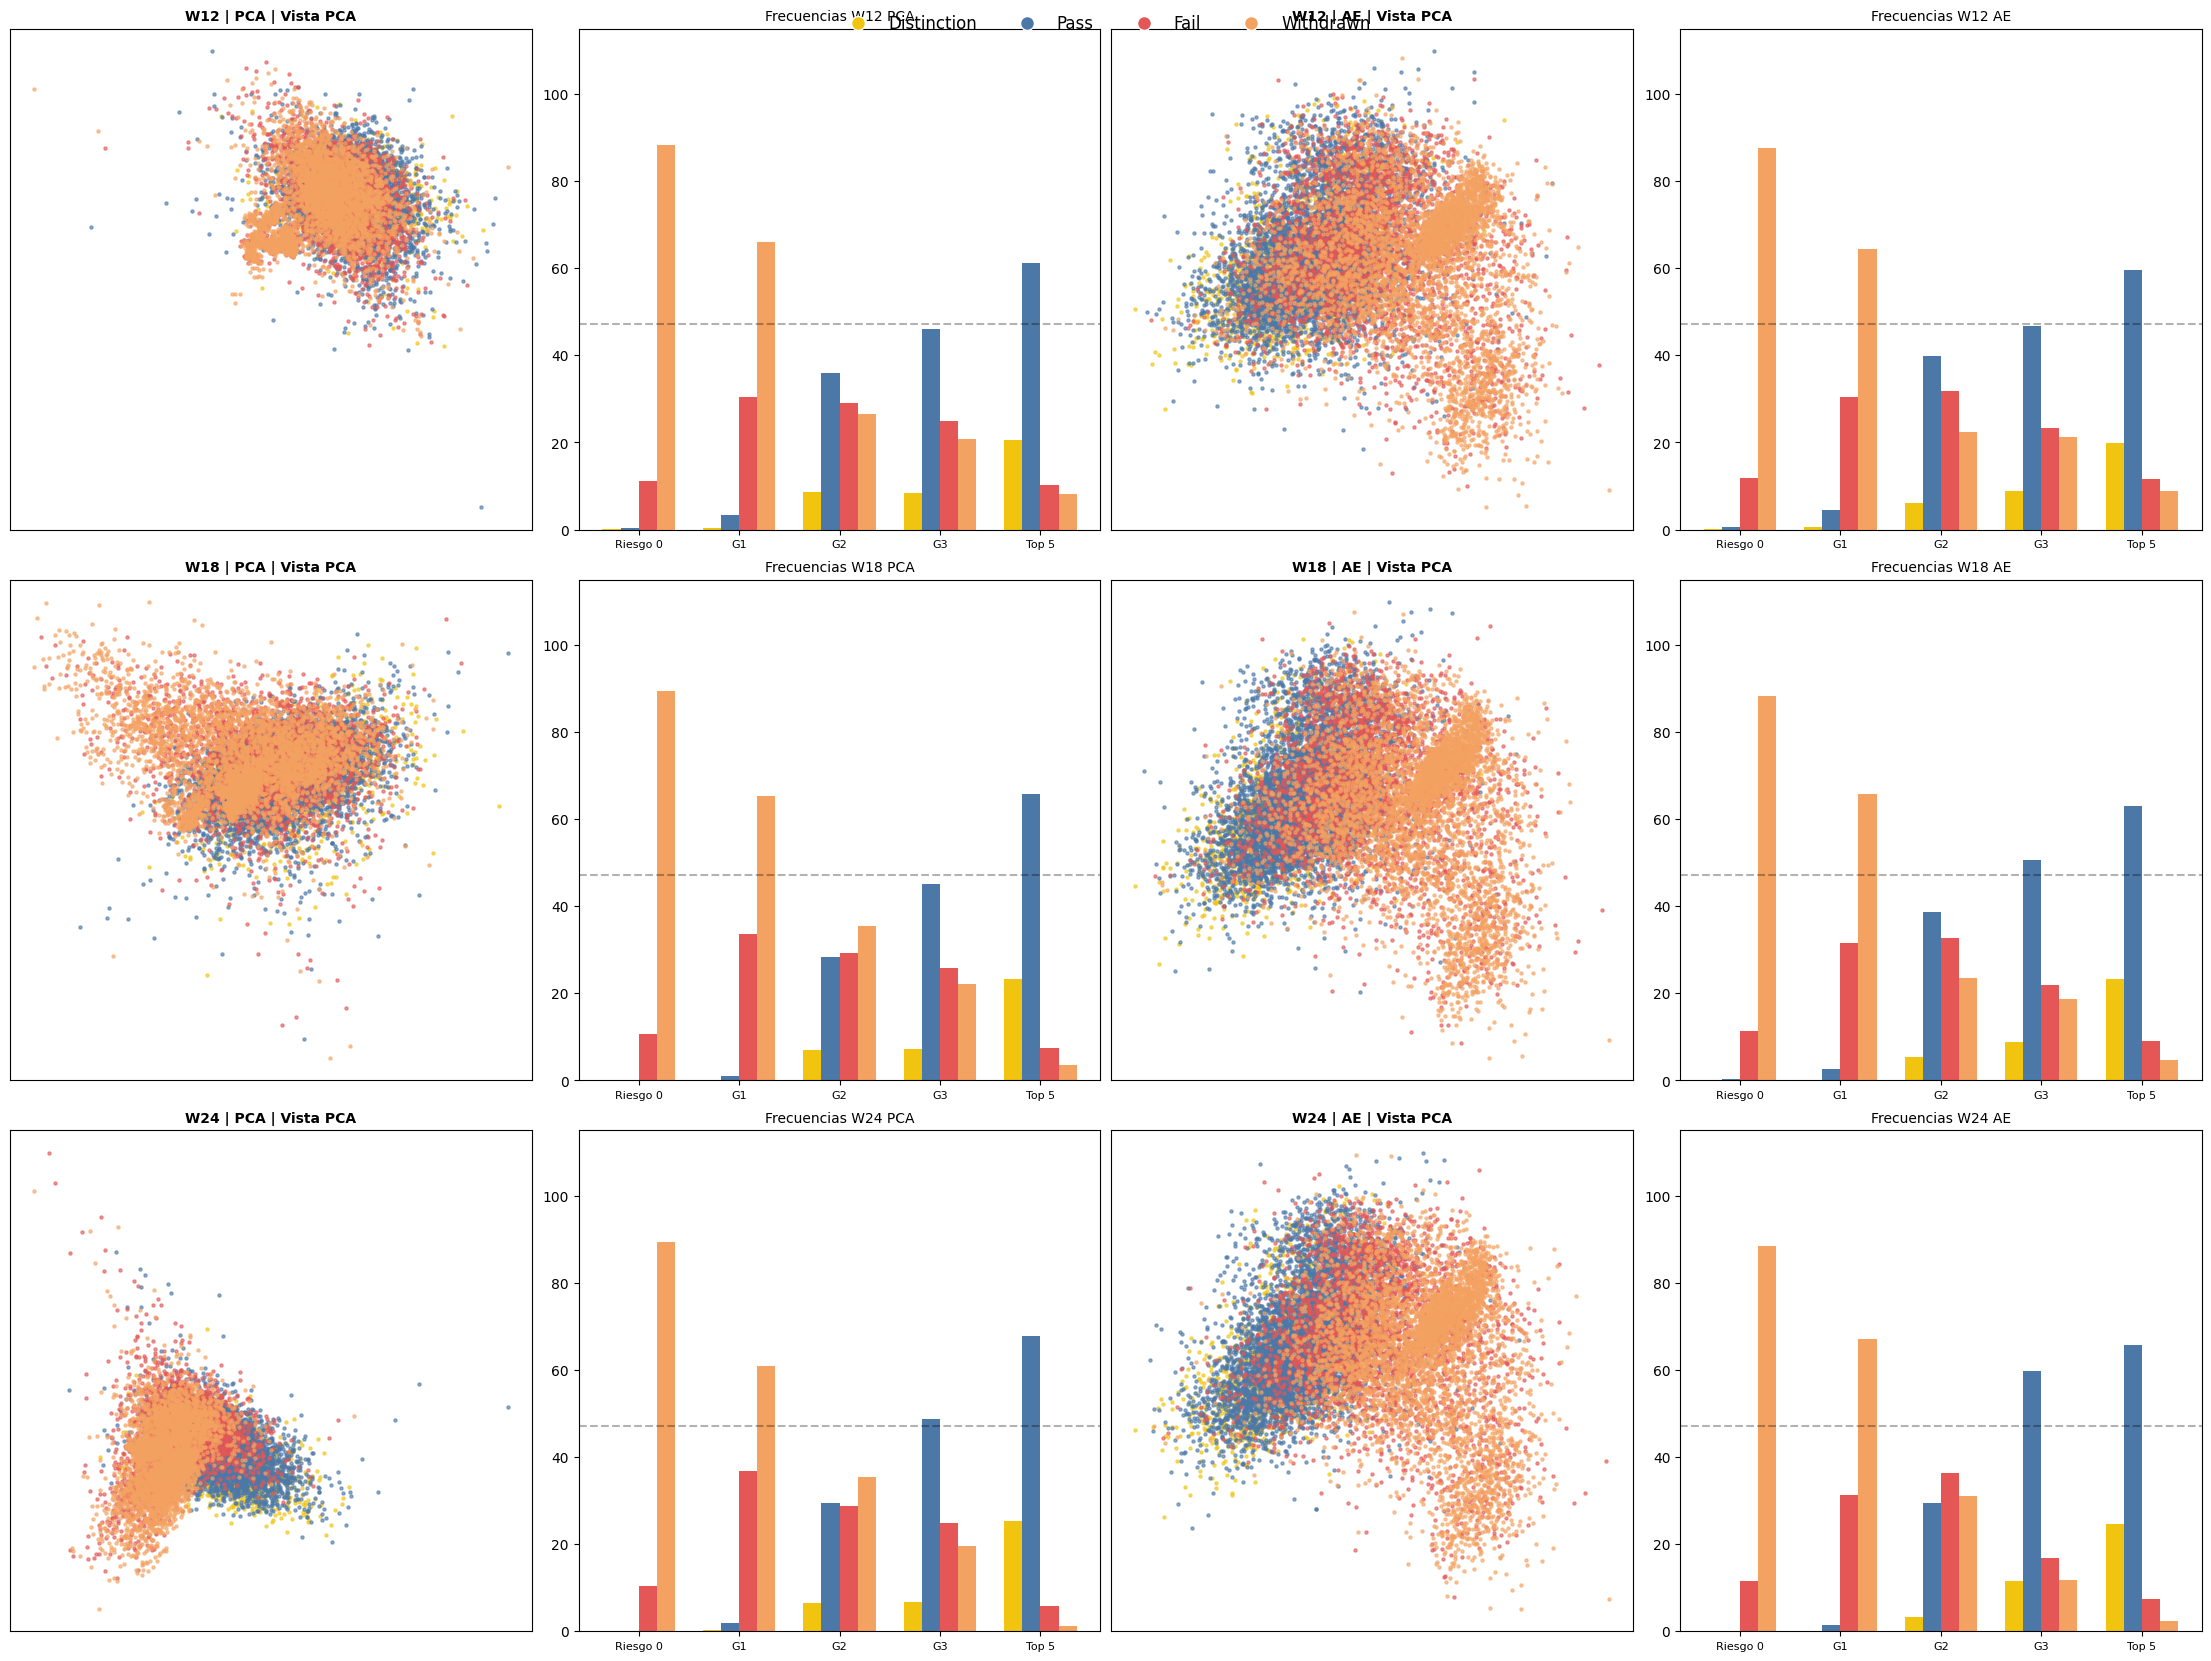

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display, Markdown

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Silenciar ruidos
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.filterwarnings("ignore")

# ---- Config del proyecto ----
try:
    from educational_ai_analytics.config import EMBEDDINGS_DATA_DIR, W_WINDOWS, FEATURES_DATA_DIR
    # (centralizado en COMUNES) LABELS_PATH = FEATURES_DATA_DIR / "training" / "target.csv"
    # (centralizado en COMUNES) LABEL_COL = "final_result"
    ROOT = Path(EMBEDDINGS_DATA_DIR)
    # (centralizado en COMUNES) WS_TO_PLOT = list(W_WINDOWS)
except Exception:
    ROOT = Path("/workspace/TFM_education_ai_analytics/data/4_embeddings")
    # (centralizado en COMUNES) LABELS_PATH = Path("/workspace/TFM_education_ai_analytics/data/3_features/training/target.csv")
    # (centralizado en COMUNES) LABEL_COL = "final_result"
    # (centralizado en COMUNES) WS_TO_PLOT = [12, 18, 24]

# ========= CONFIG =========
# (centralizado en COMUNES) SPLIT = "training"
# (centralizado en COMUNES) EMB_TYPES = ["pca", "ae"]
K = 5
# (centralizado en COMUNES) SEED = 42
# (centralizado en COMUNES) MAX_POINTS_PLOT = 15000
# (centralizado en COMUNES) MAX_POINTS_METRICS = 5000

# (centralizado en COMUNES) MAP_NUM_TO_STR = {3: "Distinction", 2: "Pass", 1: "Fail", 0: "Withdrawn"}
# (centralizado en COMUNES) OUTCOMES = ["Distinction", "Pass", "Fail", "Withdrawn"]
# (centralizado en COMUNES) OUTCOME_COLORS = {"Distinction": "#f1c40f", "Pass": "#4c78a8", "Fail": "#e45756", "Withdrawn": "#f4a261"}
# =========================

def safe_read_csv(path: Path) -> pd.DataFrame:
    if not path.exists(): return pd.DataFrame()
    return pd.read_csv(path, index_col=0).replace([np.inf, -np.inf], np.nan).fillna(0.0)

# Cargar labels
labels_df = pd.read_csv(LABELS_PATH, index_col=0)
y_outcome = labels_df[LABEL_COL].map(MAP_NUM_TO_STR)
global_success = (labels_df[LABEL_COL] >= 2).mean() * 100

# ==========================================
# 1. CÁLCULO DE MÉTRICAS Y TABLA SUMMARY
# ==========================================
metrics_results = []
for W in WS_TO_PLOT:
    for emb_type in EMB_TYPES:
        path = ROOT / SPLIT / f"upto_w{W:02d}" / f"{emb_type}_latent.csv"
        if not path.exists(): continue
        df_lat = safe_read_csv(path).loc[labels_df.index].dropna()
        if len(df_lat) > MAX_POINTS_METRICS:
            df_lat = df_lat.sample(n=MAX_POINTS_METRICS, random_state=SEED)
        X = StandardScaler().fit_transform(df_lat.values.astype(np.float32))
        gmm = GaussianMixture(
            n_components=K,
            covariance_type="tied",
            init_params="kmeans",
            n_init=20,
            max_iter=1000,
            tol=1e-3,
            reg_covar=1e-5,
            random_state=SEED,
        )
        cl = gmm.fit_predict(X)
        metrics_results.append({
            "Semana": W, "Embedding": emb_type.upper(), 
            "Silueta": silhouette_score(X, cl), 
            "Calinski-Harabasz": calinski_harabasz_score(X, cl), 
            "Davies-Bouldin": davies_bouldin_score(X, cl)
        })

df_stats = pd.DataFrame(metrics_results)
metric_meta = [
    ("Silueta", "Maximizar", "Mide separación y cohesión (-1 a 1)."),
    ("Calinski-Harabasz", "Maximizar", "Ratio de dispersión entre/dentro de clústeres."),
    ("Davies-Bouldin", "Minimizar", "Mide similitud media entre clústeres.")
]

summary_table = []
for name, obj, desc in metric_meta:
    for W in WS_TO_PLOT:
        row = {"Métrica": f"{name} (W{W})", "Objetivo": obj, "Descripción": desc}
        for emb in ["PCA", "AE"]:
            val = df_stats[(df_stats["Semana"] == W) & (df_stats["Embedding"] == emb)][name].values
            row[f"Valor {emb}"] = f"{val[0]:.4f}" if len(val) > 0 else "N/A"
        summary_table.append(row)

display(Markdown("### 📊 Calidad de Clustering (GMM): PCA vs Autoencoder"))
display(pd.DataFrame(summary_table))

# ==========================================
# 2. GENERACIÓN DE GRÁFICOS
# ==========================================
def plot_freq_bars(ax, df_join: pd.DataFrame, group_order: list[str], title: str):
    tab = pd.crosstab(df_join["group"], df_join["outcome"], normalize="index") * 100
    for out in OUTCOMES:
        if out not in tab.columns: tab[out] = 0.0
    tab = tab.loc[group_order, OUTCOMES]
    x = np.arange(len(group_order))
    width = 0.18
    for i, out in enumerate(OUTCOMES):
        ax.bar(x + (i - 1.5) * width, tab[out].values, width=width, label=out, color=OUTCOME_COLORS[out])
    ax.axhline(global_success, color="black", linestyle="--", alpha=0.3)
    ax.set_title(title, fontsize=10)
    ax.set_xticks(x); ax.set_xticklabels(group_order, fontsize=8); ax.set_ylim(0, 115)

# Acondicionar grid
Ws = [W for W in WS_TO_PLOT if any((ROOT / SPLIT / f"upto_w{W:02d}" / f"{t}_latent.csv").exists() for t in EMB_TYPES)]
nrows = len(Ws)
fig, axes = plt.subplots(nrows, 4, figsize=(22, 5.5*nrows), constrained_layout=True)
if nrows == 1: axes = np.expand_dims(axes, axis=0)

handles = [plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=OUTCOME_COLORS[out], markersize=10, label=out) for out in OUTCOMES]
fig.legend(handles=handles, labels=OUTCOMES, loc="upper center", ncol=4, frameon=False, fontsize=12)

for r, W in enumerate(Ws):
    for c, emb_type in enumerate(["pca", "ae"]):
        df_emb = safe_read_csv(ROOT / SPLIT / f"upto_w{W:02d}" / f"{emb_type}_latent.csv")
        df_join = df_emb.join(y_outcome.rename("outcome"), how="inner")
        if len(df_join) > MAX_POINTS_PLOT:
            df_join = df_join.sample(n=MAX_POINTS_PLOT, random_state=SEED)

        X = StandardScaler().fit_transform(df_join.drop(columns=["outcome"]).values.astype(np.float32))
        gmm = GaussianMixture(n_components=K, covariance_type="diag", n_init=10, random_state=SEED)
        df_join["cluster"] = gmm.fit_predict(X)
        
        # Ordenar por éxito (Pass + Distinction)
        rates = df_join.groupby("cluster")["outcome"].apply(lambda s: np.mean([v in ("Pass", "Distinction") for v in s])).sort_values()
        mapping = {cl: (f"Riesgo {i}" if i==0 else (f"Top {K}" if i==K-1 else f"G{i}")) for i, cl in enumerate(rates.index)}
        df_join["group"] = df_join["cluster"].map(mapping)
        group_order = [mapping[cl] for cl in rates.index]

        Z2 = PCA(n_components=2, random_state=SEED).fit_transform(X)
        
        # Scatter (Color por OUTCOME para ver distribución real)
        ax_sc = axes[r, c*2]
        for out in OUTCOMES:
            m = df_join["outcome"] == out
            ax_sc.scatter(Z2[m, 0], Z2[m, 1], s=5, alpha=0.6, c=OUTCOME_COLORS[out])
        ax_sc.set_title(f"W{W} | {emb_type.upper()} | Vista PCA", fontsize=10, fontweight='bold')
        ax_sc.set_xticks([]); ax_sc.set_yticks([])

        # Bars
        plot_freq_bars(axes[r, c*2+1], df_join, group_order, f"Frecuencias W{W} {emb_type.upper()}")

plt.show()

## 3. Comparativa de métricas (rápida)

Una vez tienes candidatos, aquí solemos mirar una tabla de **Silhouette / Calinski-Harabasz / Davies-Bouldin** para comparar enfoques sin casarnos con uno demasiado pronto.

In [ ]:
# Configuración de la sección (Comparativa)
METRICS_MAX_POINTS = MAX_POINTS_METRICS


In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
from IPython.display import display, Markdown

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Silenciar ruidos
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.filterwarnings("ignore")

# ---- Configuración de Rutas ----
try:
    from educational_ai_analytics.config import EMBEDDINGS_DATA_DIR, W_WINDOWS, FEATURES_DATA_DIR
    ROOT = Path(EMBEDDINGS_DATA_DIR)
    # (centralizado en COMUNES) WS_TO_PLOT = list(W_WINDOWS)
except Exception:
    ROOT = Path("/workspace/TFM_education_ai_analytics/data/4_embeddings")
    # (centralizado en COMUNES) WS_TO_PLOT = [12, 18, 24]

# ========= CONFIGURACIÓN =========
# (centralizado en COMUNES) SPLIT = "training"
K = 5
# (centralizado en COMUNES) MAX_POINTS_METRICS = 5000  # Para velocidad
# (centralizado en COMUNES) SEED = 42
# =================================

def safe_read_csv(path: Path) -> pd.DataFrame:
    if not path.exists(): return pd.DataFrame()
    return pd.read_csv(path, index_col=0).replace([np.inf, -np.inf], np.nan).fillna(0.0)

results = []

for W in WS_TO_PLOT:
    for emb_type in ["pca", "ae"]:
        path = ROOT / SPLIT / f"upto_w{W:02d}" / f"{emb_type}_latent.csv"
        if not path.exists(): continue
        
        df_lat = safe_read_csv(path)
        if len(df_lat) > MAX_POINTS_METRICS:
            df_lat = df_lat.sample(n=MAX_POINTS_METRICS, random_state=SEED)
            
        X = StandardScaler().fit_transform(df_lat.values.astype(np.float32))
        
        # --- K-MEANS ---
        km = KMeans(n_clusters=K, n_init=10, random_state=SEED)
        km_labels = km.fit_predict(X)
        
        # --- GMM ---
        gmm = GaussianMixture(n_components=K, covariance_type="diag", n_init=5, random_state=SEED)
        gmm_labels = gmm.fit_predict(X)
        
        # Guardar métricas para ambos
        for model_name, labels in [("K-Means", km_labels), ("GMM", gmm_labels)]:
            results.append({
                "Semana": f"W{W}",
                "Embedding": emb_type.upper(),
                "Modelo": model_name,
                "Silueta": silhouette_score(X, labels),
                "Calinski-Harabasz": calinski_harabasz_score(X, labels),
                "Davies-Bouldin": davies_bouldin_score(X, labels)
            })

df_all = pd.DataFrame(results)

def display_comparison_table(emb_type):
    df_emb = df_all[df_all["Embedding"] == emb_type]
    
    # Crear estructura de tabla comparativa
    table_rows = []
    metrics = [("Silueta", "Maximizar"), ("Calinski-Harabasz", "Maximizar"), ("Davies-Bouldin", "Minimizar")]
    
    for metric, obj in metrics:
        for W in [f"W{w}" for w in WS_TO_PLOT]:
            subset = df_emb[df_emb["Semana"] == W]
            val_km = subset[subset["Modelo"] == "K-Means"][metric].values[0]
            val_gmm = subset[subset["Modelo"] == "GMM"][metric].values[0]
            
            # Marcar el ganador
            if obj == "Maximizar":
                win = "GMM" if val_gmm > val_km else "K-Means"
            else:
                win = "GMM" if val_gmm < val_km else "K-Means"
                
            table_rows.append({
                "Métrica": f"{metric} ({W})",
                "K-Means": f"{val_km:.4f}",
                "GMM": f"{val_gmm:.4f}",
                "Objetivo": obj,
                "Ganador": f"⭐ {win}"
            })
    
    display(Markdown(f"### 🏆 Comparativa Modelos: **{emb_type}**"))
    display(pd.DataFrame(table_rows))

# Generar las dos tablas
display_comparison_table("PCA")
display_comparison_table("AE")

### 🏆 Comparativa Modelos: **PCA**

,Métrica,K-Means,GMM,Objetivo,Ganador
0,Silueta (W12),0.0688,0.0327,Maximizar,⭐ K-Means
1,Silueta (W18),0.0567,0.0110,Maximizar,⭐ K-Means
2,Silueta (W24),0.0702,0.0179,Maximizar,⭐ K-Means
3,Calinski-Harabasz (W12),203.0231,145.6243,Maximizar,⭐ K-Means
4,Calinski-Harabasz (W18),188.7512,142.4957,Maximizar,⭐ K-Means
5,Calinski-Harabasz (W24),196.2597,149.4703,Maximizar,⭐ K-Means
6,Davies-Bouldin (W12),3.2415,4.1467,Minimizar,⭐ K-Means
7,Davies-Bouldin (W18),3.2094,4.0392,Minimizar,⭐ K-Means
8,Davies-Bouldin (W24),3.1283,4.2982,Minimizar,⭐ K-Means


### 🏆 Comparativa Modelos: **AE**

,Métrica,K-Means,GMM,Objetivo,Ganador
0,Silueta (W12),0.1274,0.1065,Maximizar,⭐ K-Means
1,Silueta (W18),0.1296,0.1013,Maximizar,⭐ K-Means
2,Silueta (W24),0.1323,0.1016,Maximizar,⭐ K-Means
3,Calinski-Harabasz (W12),695.7869,659.4620,Maximizar,⭐ K-Means
4,Calinski-Harabasz (W18),722.8551,682.2237,Maximizar,⭐ K-Means
5,Calinski-Harabasz (W24),742.0120,697.2847,Maximizar,⭐ K-Means
6,Davies-Bouldin (W12),2.1576,2.2200,Minimizar,⭐ K-Means
7,Davies-Bouldin (W18),2.1632,2.2675,Minimizar,⭐ K-Means
8,Davies-Bouldin (W24),2.1407,2.2498,Minimizar,⭐ K-Means


## 4. Clustering jerárquico

Jerárquico sirve mucho para “ver” estructura: dendrograma, cortes y estabilidad. Ojo: si el dataset es grande puede ser pesado, por eso el muestreo importa.

In [ ]:
# Configuración de la sección (Jerárquico)
HCLUST_LINKAGE = LINKAGE
HCLUST_MAX_POINTS = MAX_POINTS_METRICS


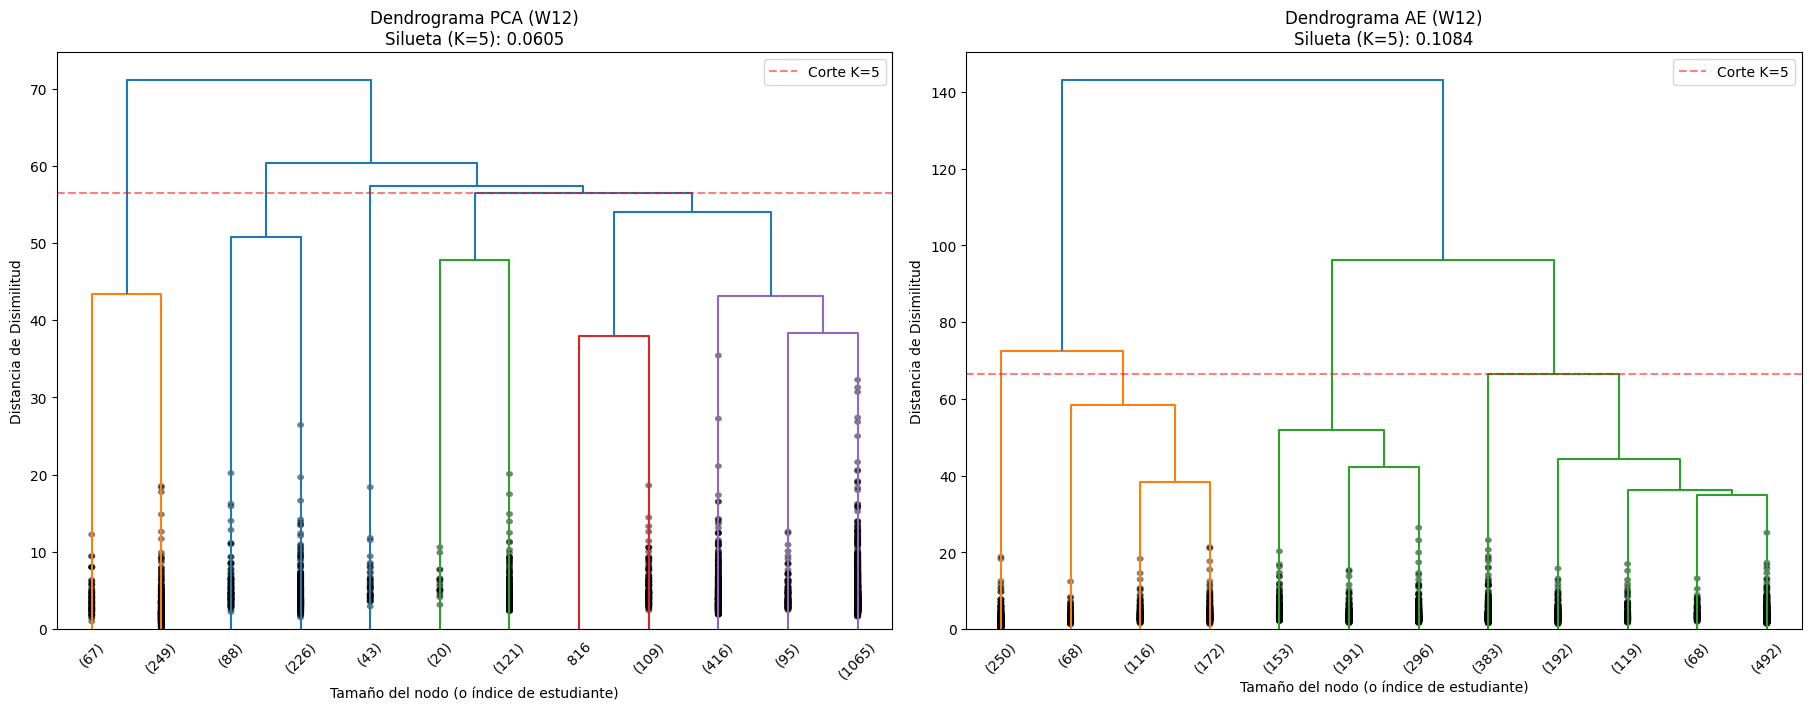

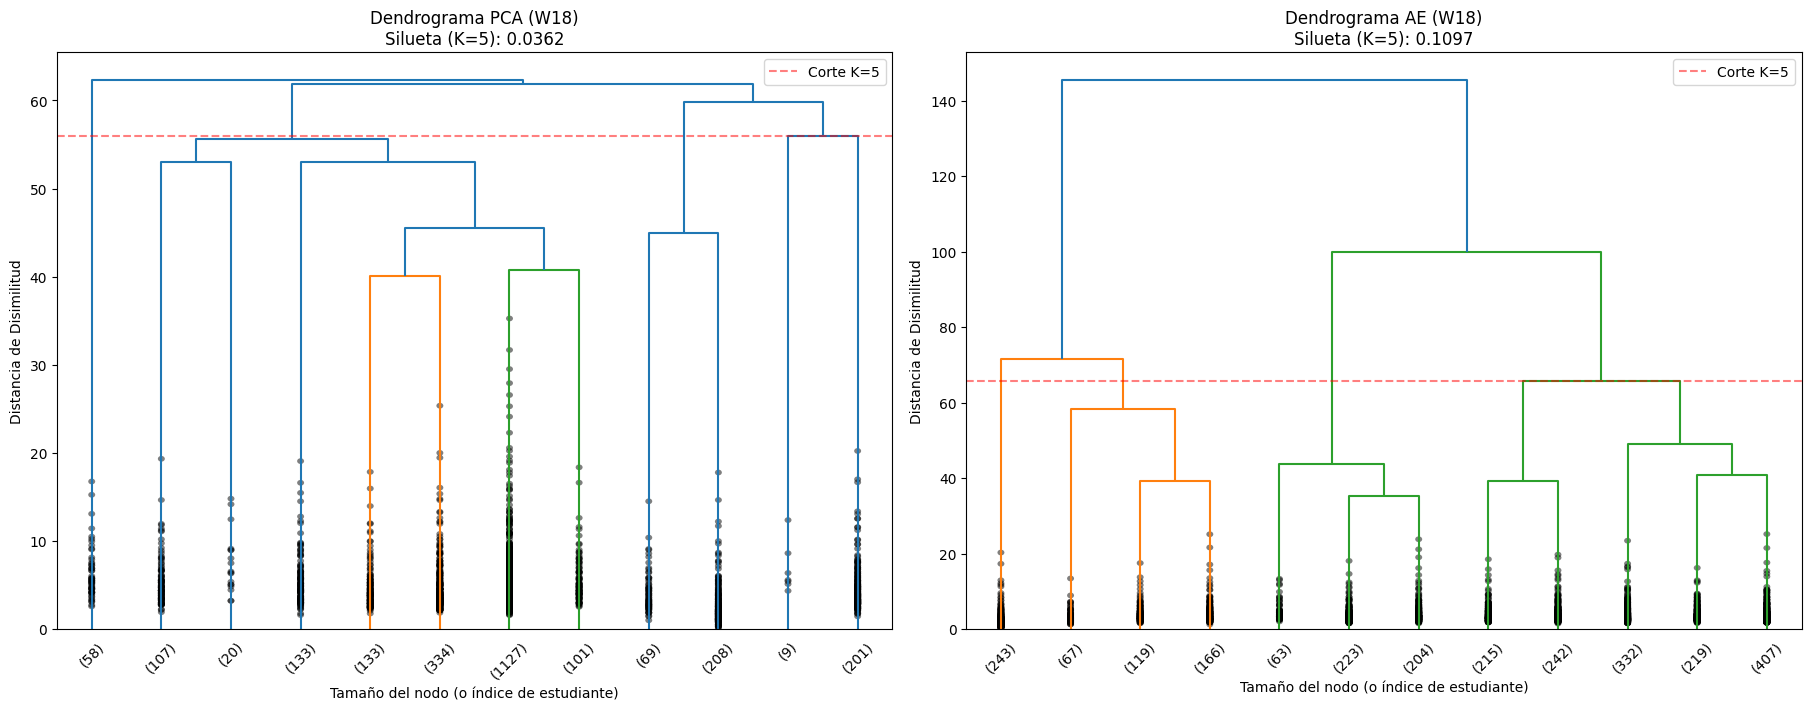

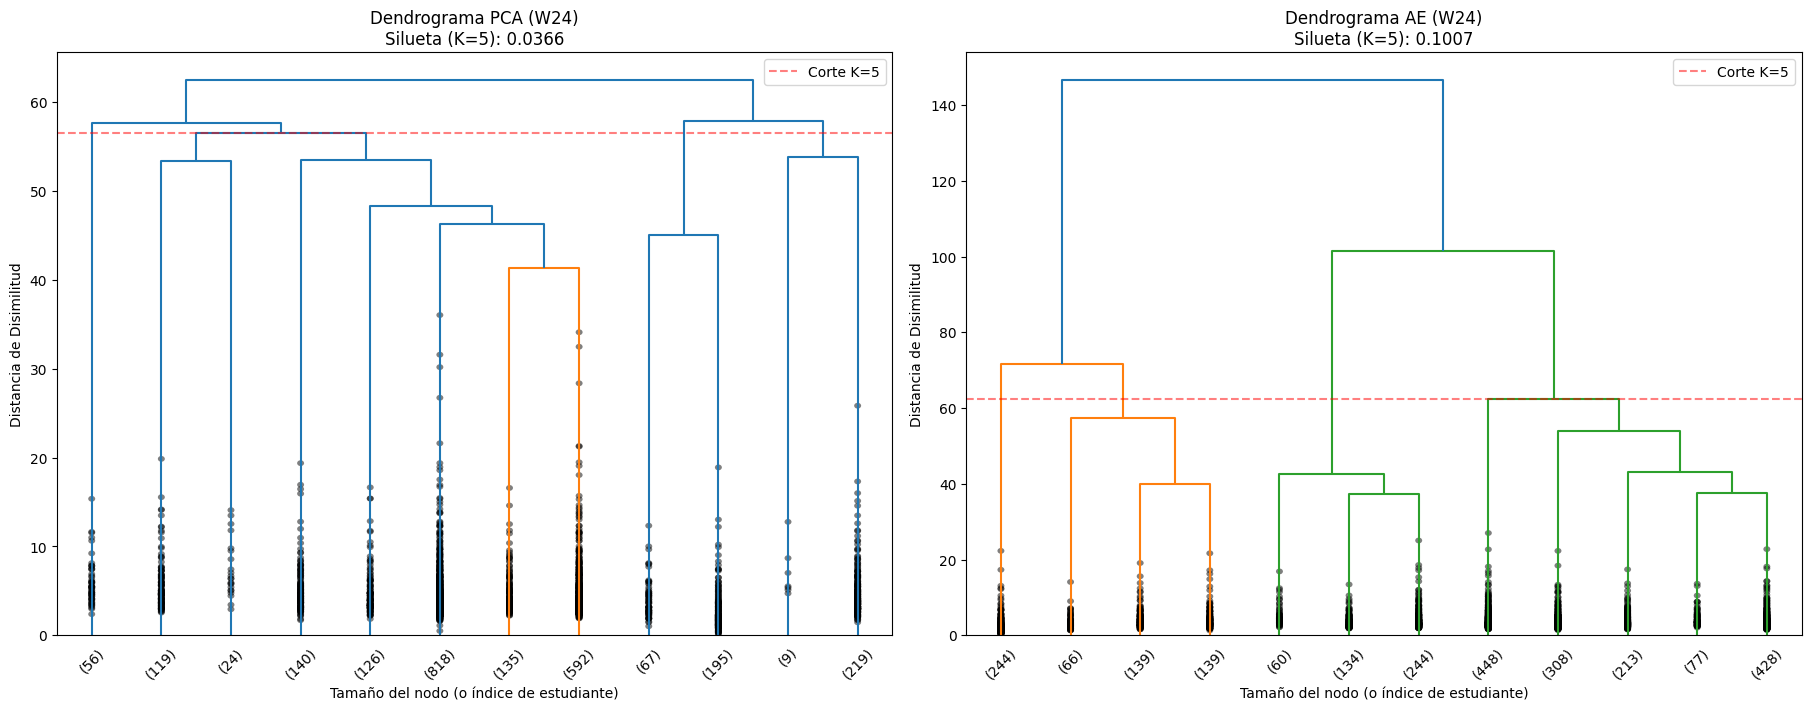

✅ Análisis Jerárquico completado.


In [ ]:
# 🌳 Clustering Jerárquico y Dendrogramas
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# ---- Configuración de Rutas ----
try:
    from educational_ai_analytics.config import EMBEDDINGS_DATA_DIR, W_WINDOWS
    ROOT = Path(EMBEDDINGS_DATA_DIR)
    # (centralizado en COMUNES) WS_TO_PLOT = list(W_WINDOWS)
except Exception:
    ROOT = Path("/workspace/TFM_education_ai_analytics/data/4_embeddings")
    # (centralizado en COMUNES) WS_TO_PLOT = [12, 18, 24]

# ========= CONFIGURACIÓN =========
# (centralizado en COMUNES) SPLIT = "training"
K = 5
# (centralizado en COMUNES) MAX_POINTS_HIERARCHICAL = 2500  # <--- Mantén esto bajo (2000-3000) para evitar cuelgues
# (centralizado en COMUNES) SEED = 42
METRIC = "euclidean"
# (centralizado en COMUNES) LINKAGE = "ward"  # "ward" minimiza la varianza dentro de los clusters
# =================================

def safe_read_csv(path: Path) -> pd.DataFrame:
    if not path.exists(): return pd.DataFrame()
    return pd.read_csv(path, index_col=0).replace([np.inf, -np.inf], np.nan).fillna(0.0)

for W in WS_TO_PLOT:
    fig, axes = plt.subplots(1, 2, figsize=(18, 7), constrained_layout=True)
    
    for j, emb_type in enumerate(["pca", "ae"]):
        ax = axes[j]
        path = ROOT / SPLIT / f"upto_w{W:02d}" / f"{emb_type}_latent.csv"
        if not path.exists(): continue
        
        df_lat = safe_read_csv(path)
        # Muestreo limitado por complejidad O(N^2)
        if len(df_lat) > MAX_POINTS_HIERARCHICAL:
            df_lat = df_lat.sample(n=MAX_POINTS_HIERARCHICAL, random_state=SEED)
            
        X = StandardScaler().fit_transform(df_lat.values.astype(np.float32))
        
        # 1. Generar la matriz de enlace (Linkage Matrix)
        Z = linkage(X, method=LINKAGE, metric=METRIC)
        
        # 2. Dibujar Dendrograma
        dendrogram(
            Z,
            truncate_mode='lastp',  # mostrar solo los últimos p clusters fusionados
            p=12,                   # número de ramas finales
            leaf_rotation=45.,
            leaf_font_size=10.,
            show_contracted=True,
            ax=ax
        )
        
        # 3. Calcular Silueta para K sugerido
        agg = AgglomerativeClustering(n_clusters=K, linkage=LINKAGE)
        labels = agg.fit_predict(X)
        s_score = silhouette_score(X, labels)
        
        ax.set_title(f"Dendrograma {emb_type.upper()} (W{W})\nSilueta (K={K}): {s_score:.4f}")
        ax.set_xlabel("Tamaño del nodo (o índice de estudiante)")
        ax.set_ylabel("Distancia de Disimilitud")
        ax.axhline(y=Z[-(K-1), 2], color='r', linestyle='--', alpha=0.5, label=f'Corte K={K}')
        ax.legend()

    plt.show()

print("✅ Análisis Jerárquico completado.")

### 📊 Calidad de Clustering Jerárquico (ward): PCA vs Autoencoder

,Métrica,Objetivo,Descripción,Valor PCA,Valor AE
0,Silueta (W12),Maximizar,Diferenciación y cohesión de ramas del árbol.,0.0565,0.1065
1,Silueta (W18),Maximizar,Diferenciación y cohesión de ramas del árbol.,0.0413,0.1008
2,Silueta (W24),Maximizar,Diferenciación y cohesión de ramas del árbol.,0.0331,0.0962
3,Calinski-Harabasz (W12),Maximizar,Ratio de dispersión de la jerarquía.,113.4463,352.7404
4,Calinski-Harabasz (W18),Maximizar,Ratio de dispersión de la jerarquía.,107.4284,369.4886
5,Calinski-Harabasz (W24),Maximizar,Ratio de dispersión de la jerarquía.,99.3015,384.5945
6,Davies-Bouldin (W12),Minimizar,Similitud media entre las hojas de la jerarquía.,2.5834,2.4379
7,Davies-Bouldin (W18),Minimizar,Similitud media entre las hojas de la jerarquía.,2.1651,2.3595
8,Davies-Bouldin (W24),Minimizar,Similitud media entre las hojas de la jerarquía.,2.2157,2.4116


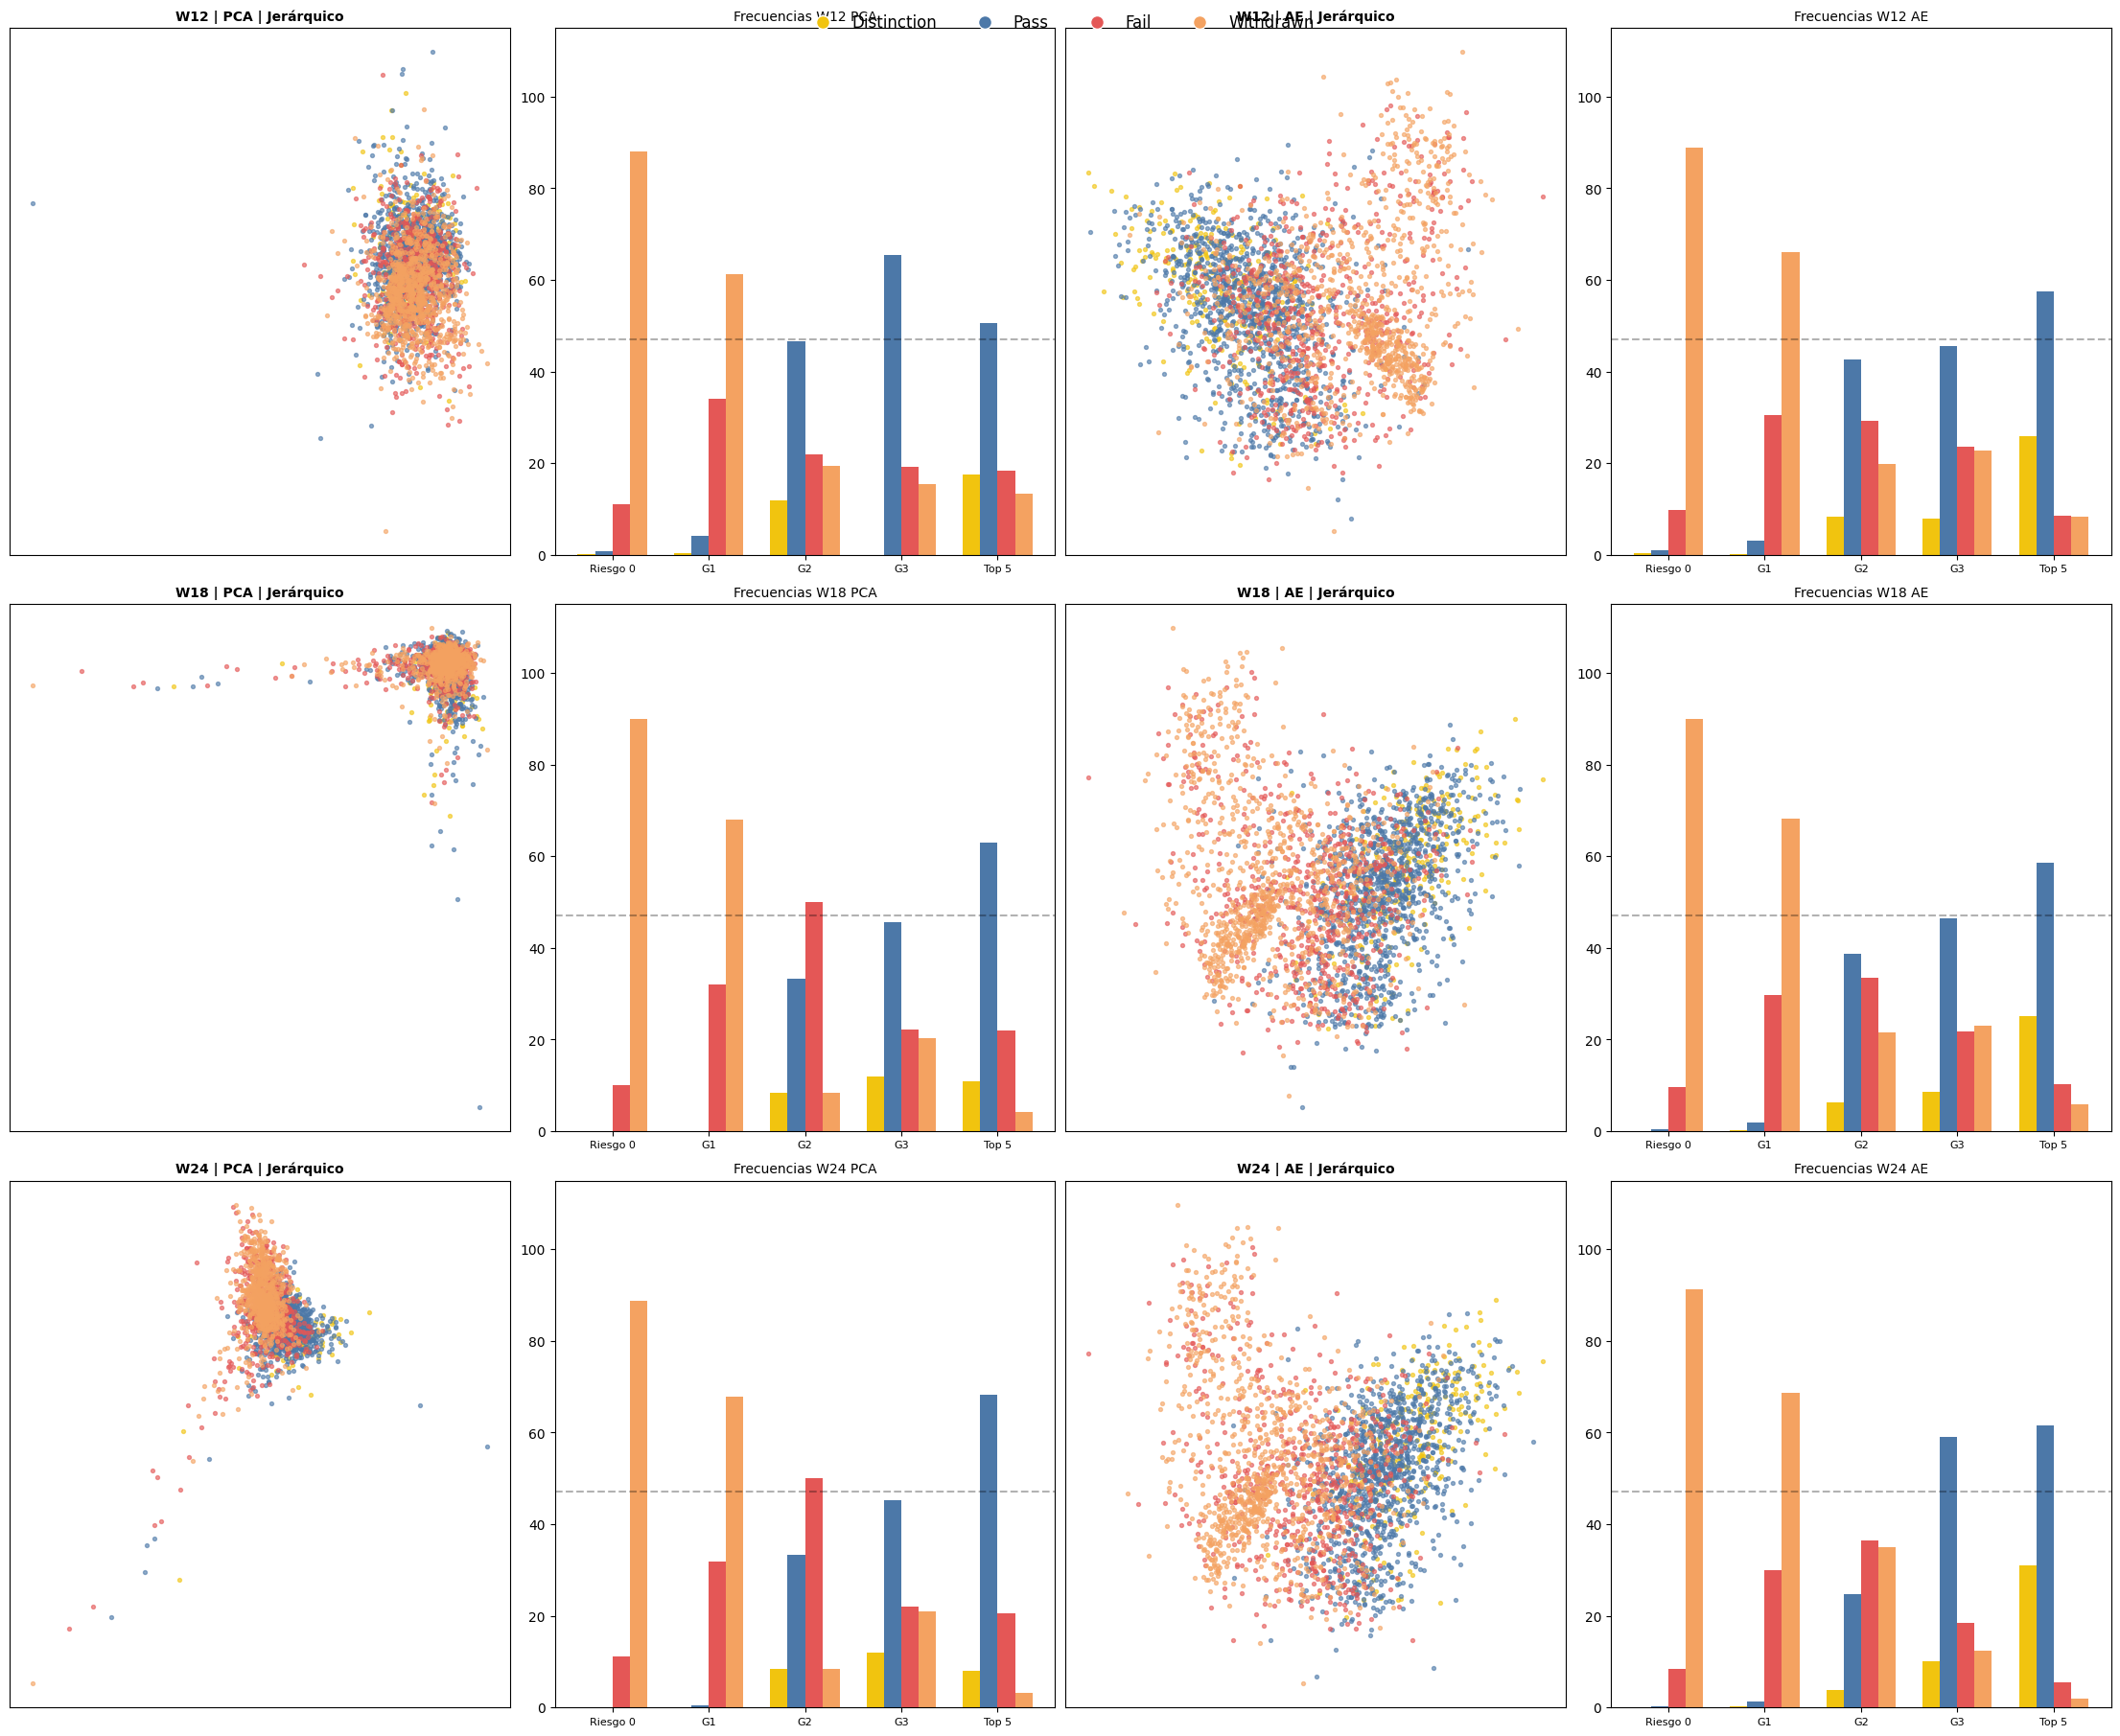

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display, Markdown

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Silenciar ruidos
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.filterwarnings("ignore")

# ---- Configuración de Rutas ----
try:
    from educational_ai_analytics.config import EMBEDDINGS_DATA_DIR, W_WINDOWS, FEATURES_DATA_DIR
    ROOT = Path(EMBEDDINGS_DATA_DIR)
    # (centralizado en COMUNES) TARGET_PATH = Path(FEATURES_DATA_DIR) / "training" / "target.csv"
    # (centralizado en COMUNES) WS_TO_PLOT = list(W_WINDOWS)
except Exception:
    ROOT = Path("/workspace/TFM_education_ai_analytics/data/4_embeddings")
    # (centralizado en COMUNES) TARGET_PATH = Path("/workspace/TFM_education_ai_analytics/data/3_features/training/target.csv")
    # (centralizado en COMUNES) WS_TO_PLOT = [12, 18, 24]

# ========= CONFIGURACIÓN =========
# (centralizado en COMUNES) SPLIT = "training"
# (centralizado en COMUNES) EMB_TYPES = ["pca", "ae"]
K = 5
# (centralizado en COMUNES) SEED = 42
# (centralizado en COMUNES) MAX_POINTS_PLOT = 3000   # Límite para visualización
# (centralizado en COMUNES) MAX_POINTS_METRICS = 3000 # Límite para cálculo de métricas (Jerárquico es O(N^2))
# (centralizado en COMUNES) LINKAGE = "ward"

# (centralizado en COMUNES) MAP_NUM_TO_STR = {3: "Distinction", 2: "Pass", 1: "Fail", 0: "Withdrawn"}
# (centralizado en COMUNES) OUTCOMES = ["Distinction", "Pass", "Fail", "Withdrawn"]
# (centralizado en COMUNES) OUTCOME_COLORS = {"Distinction": "#f1c40f", "Pass": "#4c78a8", "Fail": "#e45756", "Withdrawn": "#f4a261"}
# =================================

def safe_read_csv(path: Path) -> pd.DataFrame:
    if not path.exists(): return pd.DataFrame()
    return pd.read_csv(path, index_col=0).replace([np.inf, -np.inf], np.nan).fillna(0.0)

# Cargar labels
labels_df = pd.read_csv(TARGET_PATH, index_col=0)
y_outcome = labels_df["final_result"].map(MAP_NUM_TO_STR)
global_success = (labels_df["final_result"] >= 2).mean() * 100

# ==========================================
# 1. CÁLCULO DE MÉTRICAS Y TABLA SUMMARY
# ==========================================
metrics_results = []
for W in WS_TO_PLOT:
    for emb_type in EMB_TYPES:
        path = ROOT / SPLIT / f"upto_w{W:02d}" / f"{emb_type}_latent.csv"
        if not path.exists(): continue
        df_lat = safe_read_csv(path).loc[labels_df.index].dropna()
        if len(df_lat) > MAX_POINTS_METRICS:
            df_lat = df_lat.sample(n=MAX_POINTS_METRICS, random_state=SEED)
        
        X = StandardScaler().fit_transform(df_lat.values.astype(np.float32))
        agg = AgglomerativeClustering(n_clusters=K, linkage=LINKAGE)
        labels = agg.fit_predict(X)
        
        metrics_results.append({
            "Semana": W, "Embedding": emb_type.upper(), 
            "Silueta": silhouette_score(X, labels), 
            "Calinski-Harabasz": calinski_harabasz_score(X, labels), 
            "Davies-Bouldin": davies_bouldin_score(X, labels)
        })

df_stats = pd.DataFrame(metrics_results)
metric_meta = [
    ("Silueta", "Maximizar", "Diferenciación y cohesión de ramas del árbol."),
    ("Calinski-Harabasz", "Maximizar", "Ratio de dispersión de la jerarquía."),
    ("Davies-Bouldin", "Minimizar", "Similitud media entre las hojas de la jerarquía.")
]

summary_table = []
for name, obj, desc in metric_meta:
    for W in WS_TO_PLOT:
        row = {"Métrica": f"{name} (W{W})", "Objetivo": obj, "Descripción": desc}
        for emb in ["PCA", "AE"]:
            val = df_stats[(df_stats["Semana"] == W) & (df_stats["Embedding"] == emb)][name].values
            row[f"Valor {emb}"] = f"{val[0]:.4f}" if len(val) > 0 else "N/A"
        summary_table.append(row)

display(Markdown(f"### 📊 Calidad de Clustering Jerárquico ({LINKAGE}): PCA vs Autoencoder"))
display(pd.DataFrame(summary_table))

# ==========================================
# 2. GENERACIÓN DE GRÁFICOS
# ==========================================
def plot_freq_bars(ax, df_join: pd.DataFrame, group_order: list[str], title: str):
    tab = pd.crosstab(df_join["group"], df_join["outcome"], normalize="index") * 100
    for out in OUTCOMES:
        if out not in tab.columns: tab[out] = 0.0
    tab = tab.loc[group_order, OUTCOMES]
    x = np.arange(len(group_order))
    width = 0.18
    for i, out in enumerate(OUTCOMES):
        ax.bar(x + (i - 1.5) * width, tab[out].values, width=width, label=out, color=OUTCOME_COLORS[out])
    ax.axhline(global_success, color="black", linestyle="--", alpha=0.3)
    ax.set_title(title, fontsize=10); ax.set_xticks(x); ax.set_xticklabels(group_order, fontsize=8); ax.set_ylim(0, 115)

Ws = [W for W in WS_TO_PLOT if any((ROOT / SPLIT / f"upto_w{W:02d}" / f"{t}_latent.csv").exists() for t in EMB_TYPES)]
nrows = len(Ws); fig, axes = plt.subplots(nrows, 4, figsize=(22, 6 * nrows), constrained_layout=True)
if nrows == 1: axes = np.expand_dims(axes, axis=0)

handles = [plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=OUTCOME_COLORS[out], markersize=10, label=out) for out in OUTCOMES]
fig.legend(handles=handles, labels=OUTCOMES, loc="upper center", ncol=4, frameon=False, fontsize=12)

for r, W in enumerate(Ws):
    for c, emb_type in enumerate(["pca", "ae"]):
        df_emb = safe_read_csv(ROOT / SPLIT / f"upto_w{W:02d}" / f"{emb_type}_latent.csv")
        df_join = df_emb.join(y_outcome.rename("outcome"), how="inner")
        if len(df_join) > MAX_POINTS_PLOT:
            df_join = df_join.sample(n=MAX_POINTS_PLOT, random_state=SEED)

        X_plot = StandardScaler().fit_transform(df_join.drop(columns=["outcome"]).values.astype(np.float32))
        agg = AgglomerativeClustering(n_clusters=K, linkage=LINKAGE)
        df_join["cluster"] = agg.fit_predict(X_plot)
        
        rates = df_join.groupby("cluster")["outcome"].apply(lambda s: np.mean([v in ("Pass", "Distinction") for v in s])).sort_values()
        mapping = {cl: (f"Riesgo {i}" if i==0 else (f"Top {K}" if i==K-1 else f"G{i}")) for i, cl in enumerate(rates.index)}
        df_join["group"] = df_join["cluster"].map(mapping); group_order = [mapping[cl] for cl in rates.index]

        Z2 = PCA(n_components=2, random_state=SEED).fit_transform(X_plot)
        ax_sc = axes[r, c*2]
        for out in OUTCOMES:
            m = df_join["outcome"] == out
            ax_sc.scatter(Z2[m, 0], Z2[m, 1], s=8, alpha=0.6, c=OUTCOME_COLORS[out])
        ax_sc.set_title(f"W{W} | {emb_type.upper()} | Jerárquico", fontsize=10, fontweight='bold')
        ax_sc.set_xticks([]); ax_sc.set_yticks([])

        plot_freq_bars(axes[r, c*2+1], df_join, group_order, f"Frecuencias W{W} {emb_type.upper()}")

plt.show()

## 5. Extra: comparativa/diagnóstico final

Cierro con una celda de diagnóstico que, según el caso, ayuda a comparar todo en el mismo formato (y a detectar rápido si un método está haciendo cosas raras).

In [ ]:
# Configuración de la sección (Extra)
EXTRA_MAX_POINTS = MAX_POINTS_METRICS


In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
from IPython.display import display, Markdown

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Silenciar ruidos
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.filterwarnings("ignore")

# ---- Configuración de Rutas ----
try:
    from educational_ai_analytics.config import EMBEDDINGS_DATA_DIR, W_WINDOWS, FEATURES_DATA_DIR
    ROOT = Path(EMBEDDINGS_DATA_DIR)
    # (centralizado en COMUNES) WS_TO_PLOT = list(W_WINDOWS)
except Exception:
    ROOT = Path("/workspace/TFM_education_ai_analytics/data/4_embeddings")
    # (centralizado en COMUNES) WS_TO_PLOT = [12, 18, 24]

# ========= CONFIGURACIÓN =========
# (centralizado en COMUNES) SPLIT = "training"
K = 5
# (centralizado en COMUNES) MAX_POINTS_METRICS = 3000  # Ajustado para que el Jerárquico no tarde demasiado
# (centralizado en COMUNES) SEED = 42
# (centralizado en COMUNES) LINKAGE = "ward"
# =================================

def safe_read_csv(path: Path) -> pd.DataFrame:
    if not path.exists(): return pd.DataFrame()
    return pd.read_csv(path, index_col=0).replace([np.inf, -np.inf], np.nan).fillna(0.0)

results = []

for W in WS_TO_PLOT:
    for emb_type in ["pca", "ae"]:
        path = ROOT / SPLIT / f"upto_w{W:02d}" / f"{emb_type}_latent.csv"
        if not path.exists(): continue
        
        df_lat = safe_read_csv(path)
        if len(df_lat) > MAX_POINTS_METRICS:
            df_lat = df_lat.sample(n=MAX_POINTS_METRICS, random_state=SEED)
            
        X = StandardScaler().fit_transform(df_lat.values.astype(np.float32))
        
        # --- 1. K-MEANS ---
        km = KMeans(n_clusters=K, n_init=10, random_state=SEED)
        km_labels = km.fit_predict(X)
        
        # --- 2. GMM ---
        gmm = GaussianMixture(n_components=K, covariance_type="diag", n_init=5, random_state=SEED)
        gmm_labels = gmm.fit_predict(X)

        # --- 3. JERÁRQUICO ---
        agg = AgglomerativeClustering(n_clusters=K, linkage=LINKAGE)
        agg_labels = agg.fit_predict(X)
        
        # Guardar métricas para los tres
        for model_name, labels in [("K-Means", km_labels), ("GMM", gmm_labels), ("Jerárquico", agg_labels)]:
            results.append({
                "Semana": f"W{W}",
                "Embedding": emb_type.upper(),
                "Modelo": model_name,
                "Silueta": silhouette_score(X, labels),
                "Calinski-Harabasz": calinski_harabasz_score(X, labels),
                "Davies-Bouldin": davies_bouldin_score(X, labels)
            })

df_all = pd.DataFrame(results)

def display_comparison_table(emb_type):
    df_emb = df_all[df_all["Embedding"] == emb_type]
    
    table_rows = []
    metrics = [("Silueta", "Maximizar"), ("Calinski-Harabasz", "Maximizar"), ("Davies-Bouldin", "Minimizar")]
    
    for metric, obj in metrics:
        for W in [f"W{w}" for w in WS_TO_PLOT]:
            subset = df_emb[df_emb["Semana"] == W]
            
            val_km = subset[subset["Modelo"] == "K-Means"][metric].values[0]
            val_gmm = subset[subset["Modelo"] == "GMM"][metric].values[0]
            val_agg = subset[subset["Modelo"] == "Jerárquico"][metric].values[0]
            
            # Encontrar el ganador entre los tres
            vals = {"K-Means": val_km, "GMM": val_gmm, "Jerárquico": val_agg}
            if obj == "Maximizar":
                winner = max(vals, key=vals.get)
            else:
                winner = min(vals, key=vals.get)
                
            table_rows.append({
                "Métrica": f"{metric} ({W})",
                "K-Means": f"{val_km:.4f}",
                "GMM": f"{val_gmm:.4f}",
                "Jerárquico": f"{val_agg:.4f}",
                "Objetivo": obj,
                "Ganador": f"⭐ {winner}"
            })
    
    display(Markdown(f"### 🏆 Comparativa Completa: **{emb_type}** (K={K})"))
    display(pd.DataFrame(table_rows))

# Generar las dos tablas comparativas
display_comparison_table("PCA")
display_comparison_table("AE")

### 🏆 Comparativa Completa: **PCA** (K=5)

,Métrica,K-Means,GMM,Jerárquico,Objetivo,Ganador
0,Silueta (W12),0.0674,0.0137,0.0565,Maximizar,⭐ K-Means
1,Silueta (W18),0.0575,0.0415,0.0413,Maximizar,⭐ K-Means
2,Silueta (W24),0.0648,0.0393,0.0331,Maximizar,⭐ K-Means
3,Calinski-Harabasz (W12),123.3097,81.7843,113.4463,Maximizar,⭐ K-Means
4,Calinski-Harabasz (W18),115.2170,93.9738,107.4284,Maximizar,⭐ K-Means
5,Calinski-Harabasz (W24),116.7043,95.2854,99.3015,Maximizar,⭐ K-Means
6,Davies-Bouldin (W12),3.2362,4.4151,2.5834,Minimizar,⭐ Jerárquico
7,Davies-Bouldin (W18),3.3789,4.0241,2.1651,Minimizar,⭐ Jerárquico
8,Davies-Bouldin (W24),3.3262,4.0524,2.2157,Minimizar,⭐ Jerárquico


### 🏆 Comparativa Completa: **AE** (K=5)

,Métrica,K-Means,GMM,Jerárquico,Objetivo,Ganador
0,Silueta (W12),0.1256,0.1019,0.1065,Maximizar,⭐ K-Means
1,Silueta (W18),0.1224,0.0995,0.1008,Maximizar,⭐ K-Means
2,Silueta (W24),0.1217,0.1046,0.0962,Maximizar,⭐ K-Means
3,Calinski-Harabasz (W12),415.9660,391.5857,352.7404,Maximizar,⭐ K-Means
4,Calinski-Harabasz (W18),429.7914,404.4545,369.4886,Maximizar,⭐ K-Means
5,Calinski-Harabasz (W24),442.6109,418.5411,384.5945,Maximizar,⭐ K-Means
6,Davies-Bouldin (W12),2.1588,2.2131,2.4379,Minimizar,⭐ K-Means
7,Davies-Bouldin (W18),2.2013,2.2570,2.3595,Minimizar,⭐ K-Means
8,Davies-Bouldin (W24),2.1787,2.3197,2.4116,Minimizar,⭐ K-Means


In [19]:
# ==========================================================
# 🚀 CELDA TODOTERRENO: CLUSTERING DAY0 (KMeans/GMM) + MÉTRICAS + ESTABILIDAD + PLOTS
# ==========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.metrics import (
    silhouette_score, davies_bouldin_score, calinski_harabasz_score,
    adjusted_rand_score
)

# -----------------------------
# ✅ CONFIG
# -----------------------------
path_day0   = Path("/workspace/TFM_education_ai_analytics/data/3_features/training/day0_static_features.csv")
path_target = Path("/workspace/TFM_education_ai_analytics/data/3_features/training/target.csv")

LABELS_MAP = {3: "Distinction", 2: "Pass", 1: "Fail", 0: "Withdrawn"}
PALETA_COLORES = {
    "Distinction": "#FFD700",
    "Pass": "#4A79B7",
    "Fail": "#C54443",
    "Withdrawn": "#E39063"
}

# Preprocesado
USE_ROBUST = True          # False -> StandardScaler
USE_PCA = True             # True -> PCA con varianza objetivo
PCA_VAR = 0.95             # varianza a conservar si USE_PCA=True

# Barrido de K
K_RANGE = range(2, 9)      # prueba K=2..8
N_RUNS = 10                # seeds para estabilidad/medias

# Modelo principal
MODEL = "kmeans"           # "kmeans" o "gmm"

RANDOM_BASE = 42

# -----------------------------
# ✅ LOAD
# -----------------------------
df_day0 = pd.read_csv(path_day0, index_col=0)
df_target = pd.read_csv(path_target, index_col=0)

X = df_day0.values.astype(np.float32)

# -----------------------------
# ✅ PREPROCESS PIPE (sin cluster)
# -----------------------------
scaler = RobustScaler() if USE_ROBUST else StandardScaler()

pre_steps = [("scaler", scaler)]
if USE_PCA:
    pre_steps.append(("pca", PCA(n_components=PCA_VAR, random_state=RANDOM_BASE)))

pre = Pipeline(pre_steps)
X_pre = pre.fit_transform(X)

print(f"X original: {X.shape}  ->  X preprocesado: {X_pre.shape}")
if USE_PCA:
    pca_obj = pre.named_steps["pca"]
    print(f"PCA: componentes={pca_obj.n_components_} | var_explicada={pca_obj.explained_variance_ratio_.sum():.3f}")

# -----------------------------
# ✅ EVALUACIÓN (KMeans o GMM)
# -----------------------------
def fit_predict_model(Xp, k, seed, model="kmeans"):
    if model == "kmeans":
        m = KMeans(n_clusters=k, random_state=seed, n_init="auto")
        labels = m.fit_predict(Xp)
        return labels, m
    elif model == "gmm":
        m = GaussianMixture(n_components=k, covariance_type="full", random_state=seed)
        labels = m.fit_predict(Xp)
        return labels, m
    else:
        raise ValueError("MODEL debe ser 'kmeans' o 'gmm'")

def metrics_for_labels(Xp, labels):
    # Silhouette requiere al menos 2 clusters y que no haya clusters vacíos (no suele pasar aquí)
    sil = silhouette_score(Xp, labels)
    db  = davies_bouldin_score(Xp, labels)
    ch  = calinski_harabasz_score(Xp, labels)
    return sil, db, ch

rows = []
for k in K_RANGE:
    labels_runs = []
    sils, dbs, chs = [], [], []
    
    for i in range(N_RUNS):
        seed = RANDOM_BASE + i
        labels, _ = fit_predict_model(X_pre, k, seed, model=MODEL)
        labels_runs.append(labels)
        sil, db, ch = metrics_for_labels(X_pre, labels)
        sils.append(sil); dbs.append(db); chs.append(ch)

    # estabilidad media ARI entre pares de runs
    aris = []
    for i in range(N_RUNS):
        for j in range(i+1, N_RUNS):
            aris.append(adjusted_rand_score(labels_runs[i], labels_runs[j]))
    mean_ari = float(np.mean(aris)) if len(aris) else np.nan
    
    rows.append({
        "k": k,
        "silhouette_mean": float(np.mean(sils)),
        "silhouette_std": float(np.std(sils)),
        "db_mean": float(np.mean(dbs)),
        "db_std": float(np.std(dbs)),
        "ch_mean": float(np.mean(chs)),
        "ch_std": float(np.std(chs)),
        "stability_ARI_mean": mean_ari
    })

df_eval = pd.DataFrame(rows).sort_values(["silhouette_mean", "stability_ARI_mean"], ascending=False)

print("\n📈 Evaluación por K (ordenada por silhouette y estabilidad):")
display(df_eval)

# Heurística de selección:
# - maximizar silhouette
# - minimizar DB
# - maximizar estabilidad ARI
# Aquí elegimos el top por silhouette, y si empate, por ARI.
best_k = int(df_eval.iloc[0]["k"])
print(f"\n✅ Mejor K según heurística: {best_k} (MODEL={MODEL})")

# -----------------------------
# ✅ ENTRENAR MODELO FINAL (seed fijo)
# -----------------------------
final_seed = RANDOM_BASE
labels_final, model_final = fit_predict_model(X_pre, best_k, final_seed, model=MODEL)

# Para GMM guardamos probs (soft assignment)
probs = None
if MODEL == "gmm":
    probs = model_final.predict_proba(X_pre)
    print(f"Soft clusters (probs) shape: {probs.shape}")

# -----------------------------
# ✅ CRUCE CON TARGET Y TABLA DE PROPORCIONES
# -----------------------------
df_res = pd.DataFrame({"cluster": labels_final}, index=df_day0.index).join(df_target[["final_result"]])

plot_data = []
for c in sorted(df_res["cluster"].unique()):
    counts = df_res[df_res["cluster"] == c]["final_result"].value_counts(normalize=True) * 100
    for val, name in LABELS_MAP.items():
        plot_data.append({
            "Cluster": f"C{c}",
            "Resultado Real": name,
            "Porcentaje": counts.get(val, 0.0)
        })
df_plot = pd.DataFrame(plot_data)

print("\n📋 PROPORCIÓN REAL POR CLUSTER:")
resumen = df_res.groupby("cluster")["final_result"].value_counts(normalize=True).unstack(fill_value=0) * 100
# asegurar columnas en orden 0..3
resumen = resumen.reindex(columns=sorted(LABELS_MAP.keys()), fill_value=0)
resumen.columns = [LABELS_MAP[c] for c in resumen.columns]
display(resumen.round(1))

# -----------------------------
# ✅ PLOT 2D PARA VISUALIZACIÓN (PCA a 2 dims solo para plot)
# -----------------------------
plot_pipe = Pipeline([
    ("scaler", scaler),
    ("pca2", PCA(n_components=2, random_state=RANDOM_BASE))
])
X_2d = plot_pipe.fit_transform(X)

var2 = plot_pipe.named_steps["pca2"].explained_variance_ratio_.sum()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7), gridspec_kw={'width_ratios':[1, 1.2]})

ax1.scatter(X_2d[:,0], X_2d[:,1], c=labels_final, cmap="viridis", s=10, alpha=0.5)
ax1.set_title(f"Estructura Espacial (PCA2) - Día 0 | var={var2:.1%} | {MODEL} K={best_k}", fontweight="bold")
ax1.set_xlabel("PC1"); ax1.set_ylabel("PC2")

sns.barplot(data=df_plot, x="Cluster", y="Porcentaje", hue="Resultado Real",
            palette=PALETA_COLORES, ax=ax2)
ax2.set_title("Composición Real de cada Cluster", fontweight="bold")
ax2.set_ylabel("% del total del cluster")
ax2.set_ylim(0, 105)
ax2.legend(bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()

# -----------------------------
# ✅ EXTRA: Guardar soft clusters o labels para downstream (transformer)
# -----------------------------
# Hard labels
df_clusters = pd.DataFrame({"cluster_day0": labels_final}, index=df_day0.index)

# Soft labels (solo GMM)
if probs is not None:
    for i in range(probs.shape[1]):
        df_clusters[f"cluster_day0_prob_{i}"] = probs[:, i]

print("\n✅ df_clusters listo para usar en downstream:")
display(df_clusters.head())

display(df_clusters.head())


X original: (22785, 15)  ->  X preprocesado: (22785, 8)
PCA: componentes=8 | var_explicada=0.952


KeyboardInterrupt: 

In [17]:
# ==========================================================
# 📈 MÉTODO DEL CODO Y SILUETA - DÍA CERO
# ==========================================================

# 1. Definir rango de K (ej: de 2 a 12)
k_range = range(2, 13)
inertias = []
silhouettes = []

# 2. Muestreo para velocidad (opcional, si el dataset es muy grande)
# X_day0 ya debería estar definido de la celda anterior
sample_size = min(len(X_day0), 20000)
idx = np.random.RandomState(SEED).choice(len(X_day0), sample_size, replace=False)
X_sample = X_day0[idx]

print(f"⏳ Calculando métricas para K entre {k_range.start} y {k_range.stop-1}...")

for k in k_range:
    km = KMeans(n_clusters=k, random_state=SEED, n_init=10)
    labels = km.fit_predict(X_day0)
    
    inertias.append(km.inertia_)
    
    # Calculamos silueta sobre la muestra para no ralentizar el proceso
    score = silhouette_score(X_sample, km.predict(X_sample), random_state=SEED)
    silhouettes.append(score)
    print(f"✅ K={k} completado.")

# 3. Visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de Inercia (Elbow) - El "codo" suele ser el punto óptimo
ax1.plot(k_range, inertias, marker='o', linestyle='-', color='b')
ax1.set_title('Método del Codo (Inercia)', fontsize=14)
ax1.set_xlabel('Número de clusters (K)')
ax1.set_ylabel('Inercia (SSE)')
ax1.grid(True, alpha=0.3)

# Gráfico de Silueta - El pico más alto suele ser el mejor K
ax2.plot(k_range, silhouettes, marker='s', linestyle='-', color='green')
ax2.set_title('Análisis de Silueta', fontsize=14)
ax2.set_xlabel('Número de clusters (K)')
ax2.set_ylabel('Avg Silhouette Score')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Conclusión automática
best_k_silh = list(k_range)[np.argmax(silhouettes)]
print(f"💡 Sugerencia basada en Silueta: K = {best_k_silh}")

⏳ Calculando métricas para K entre 2 y 12...
✅ K=2 completado.
✅ K=3 completado.


KeyboardInterrupt: 